<a id='top'></a>
# Paul Pinchuk<br>NREL Interview<br>Tuesday, November 9, 2021

In this notebook, we will implement some tools to analyze and visualize NREL’s National Solar Radiation Database (NSRDB). 

## Imports
We begin with some relevant imports.

In [ ]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import partial
from sklearn.preprocessing import StandardScaler


## Downloading the Data
We can download the data using the NSRDB API and `pandas`.

In [ ]:
def download_data(loc, year, api_key):
    lat, lon = loc
    attr = 'ghi,dhi,dni,air_temperature,solar_zenith_angle,cloud_type,ozone,wind_speed,wind_direction' # 'ghi,dhi,dni,wind_speed,wind_direction,air_temperature,cloud_type,ozone,relative_humidity,surface_pressure,total_precipitable_water,solar_zenith_angle'
    leap_year = 'false'
    interval = '30'
    utc = 'false'
    email = 'pinchukpaul@gmail.com'
    url = f'https://developer.nrel.gov/api/nsrdb/v2/solar/full-disc-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap_year}&interval={interval}&utc={utc}&email={email}&api_key={api_key}&attributes={attr}'
    info = pd.read_csv(url, nrows=1)
    data = pd.read_csv(url, skiprows=2)
    return info, data


Let's obtain the 2020 yearly data for Denver!

In [ ]:
info, data = download_data((39.7392, -104.9903), '2020', '{API KEY}')  # Denver

In [ ]:
info

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,NSRDB,1951980,-,b'Colorado',b'United States',39.74,-104.99,-7,1608,-7,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,NaN,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,3.2.0


In [ ]:
data

,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Temperature,Solar Zenith Angle,Cloud Type,Ozone,Wind Speed,Wind Direction
0,2020,1,1,0,0,0,0,0,-1.6,163.28,7,0.325,6.0,264
1,2020,1,1,0,30,0,0,0,-1.5,162.36,7,0.325,6.2,264
2,2020,1,1,1,0,0,0,0,-1.4,159.42,4,0.325,6.4,264
3,2020,1,1,1,30,0,0,0,-1.4,155.18,0,0.324,6.5,265
4,2020,1,1,2,0,0,0,0,-1.3,150.21,0,0.324,6.7,266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2020,12,31,21,30,0,0,0,-1.8,143.68,7,0.324,5.5,266
17516,2020,12,31,22,0,0,0,0,-1.7,149.11,7,0.324,5.6,267
17517,2020,12,31,22,30,0,0,0,-1.7,154.18,7,0.324,5.7,266
17518,2020,12,31,23,0,0,0,0,-1.6,158.61,1,0.325,5.8,266


As we can see, the data is neatly organized and can be used right away for visualization and/or modeling. Before we do anything else, we will group the data by day for use later:

In [ ]:
data_by_day = data.groupby(by=['Month', 'Day'])

# Data Visualization

Let's begin exploring the data by implementing some visualization tools.
First, it would be nice to see a plot of the relevant data features as a function of time. 

In [ ]:
allowed_dt = ['monthly', 'daily', 'hourly']

def plot_statistics_over_time(data, feature, dt='monthly', statistics=None):
    data = data.sort_values(by=['Year', 'Month', 'Day', 'Hour', 'Minute'])
    
    if statistics is None:
        statistics = [(np.mean, 'Mean')]

    if dt not in allowed_dt:
        raise ValueError(f"Invalid dt: {dt}. Allowed values: {allowed_dt}")

    group_vals = {
        'monthly': ["Year", "Month"],
        'daily': ["Year", "Month", "Day"],
        'hourly': ["Year", "Month", "Day", "Hour"],
    }
    x_labels = {
        'monthly': "Months",
        'daily': "Days",
        'hourly': "Hours"
    }

    dot_size = {
        'monthly': 10,
        'daily': 5,
        'hourly': 2
    }


    stats = [
        [stat(group[feature]) for __, group in data.groupby(group_vals[dt])]
        for stat, __ in statistics
    ]

    _ = plt.figure(figsize=(20, 10))
    if len(statistics) == 1:
        _ = plt.plot(stats[0], marker='o', ms=dot_size[dt]) 
    else: 
        for s, label in zip(stats, [l for __, l in statistics]):
            _ = plt.plot(s, label=label, marker='o', ms=dot_size[dt])  
        _ = plt.legend(fontsize=18)

    _ = plt.xlabel(x_labels[dt], size=18)  
    if len(statistics) == 1:
        _ = plt.ylabel(f'{feature} ({statistics[0][1]})', size=18) 
    else: 
        _ = plt.ylabel(feature, size=18)

    _ = plt.xticks(size=15)
    _ = plt.yticks(size=15)


    return stats

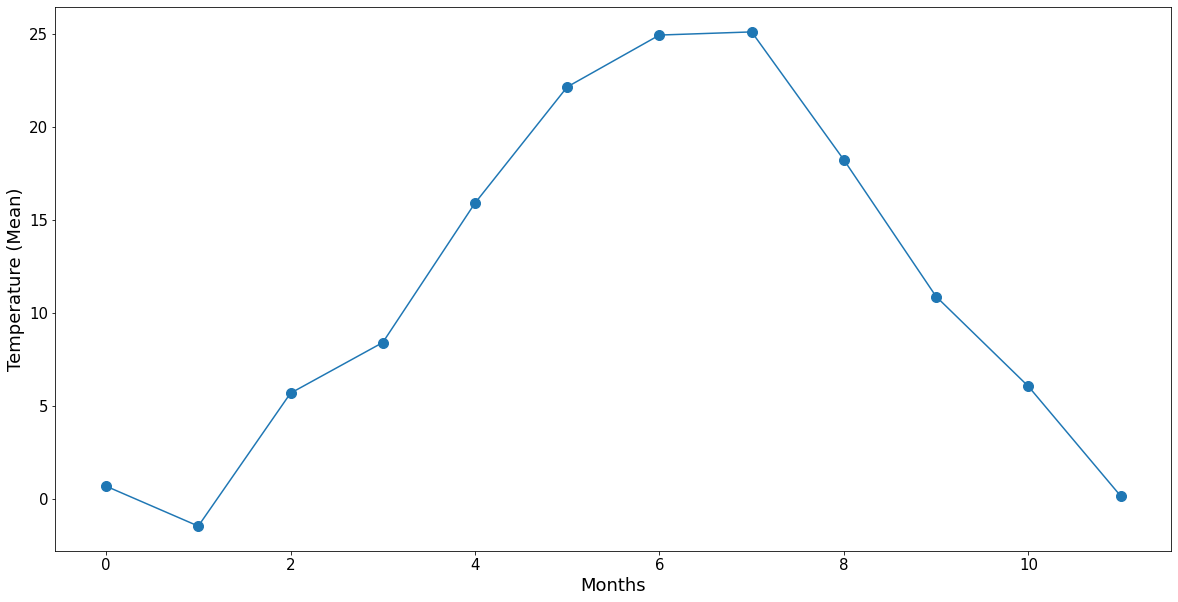

In [ ]:
stats = plot_statistics_over_time(data, feature='Temperature', dt='monthly')

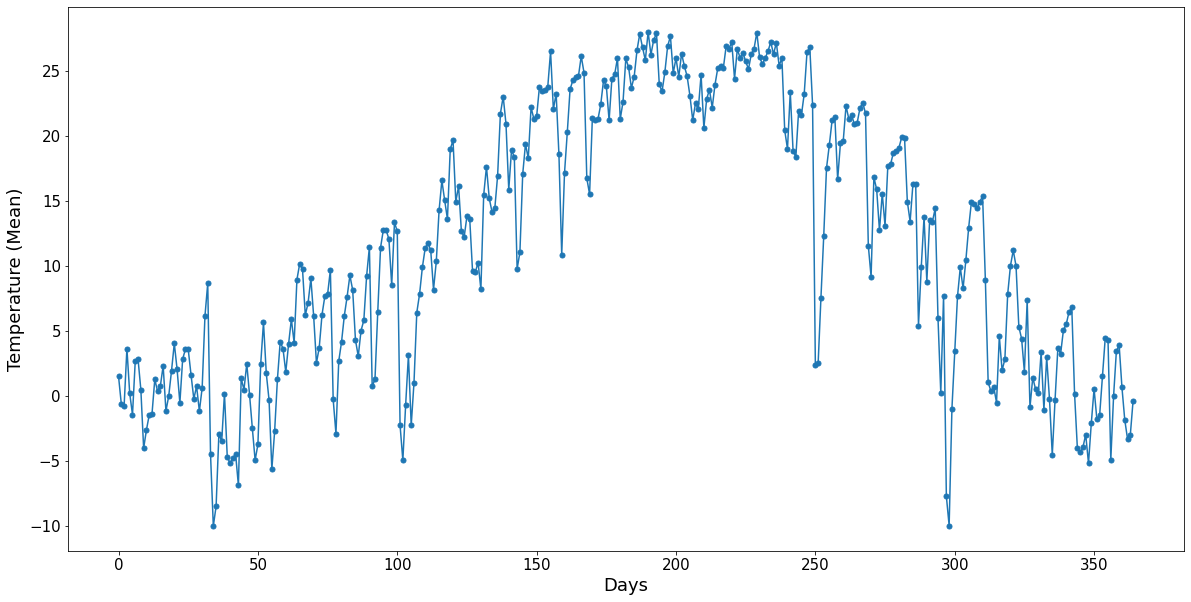

In [ ]:
stats = plot_statistics_over_time(data, feature='Temperature', dt='daily')

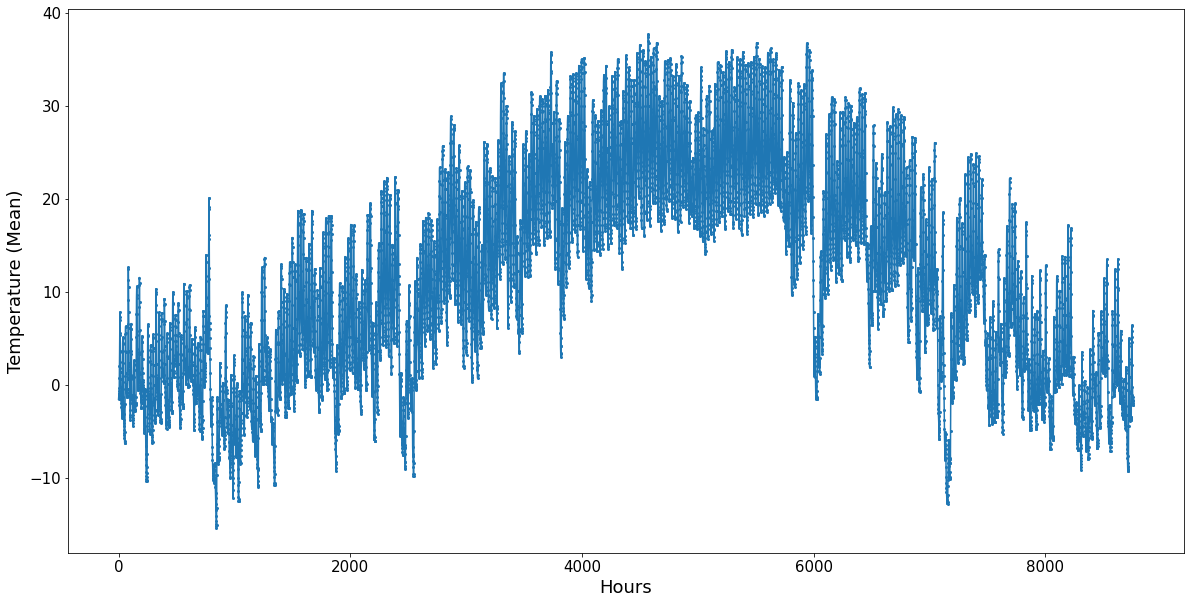

In [ ]:
stats = plot_statistics_over_time(data, feature='Temperature', dt='hourly')

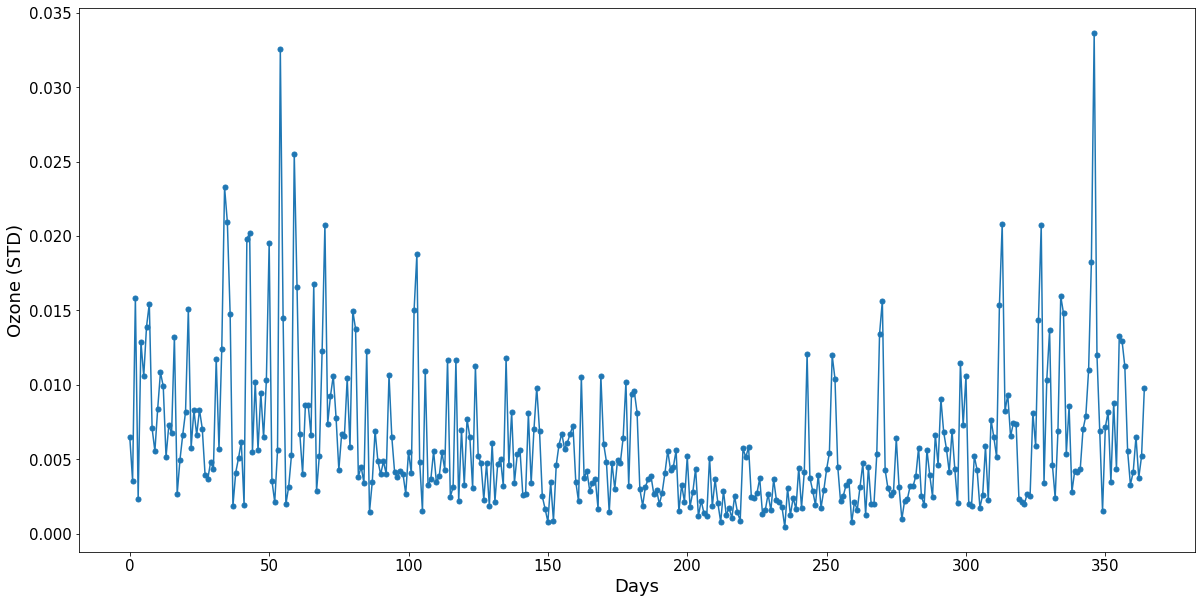

In [ ]:
stats = plot_statistics_over_time(data, feature='Ozone', dt='daily', statistics=[(np.std, 'STD')])

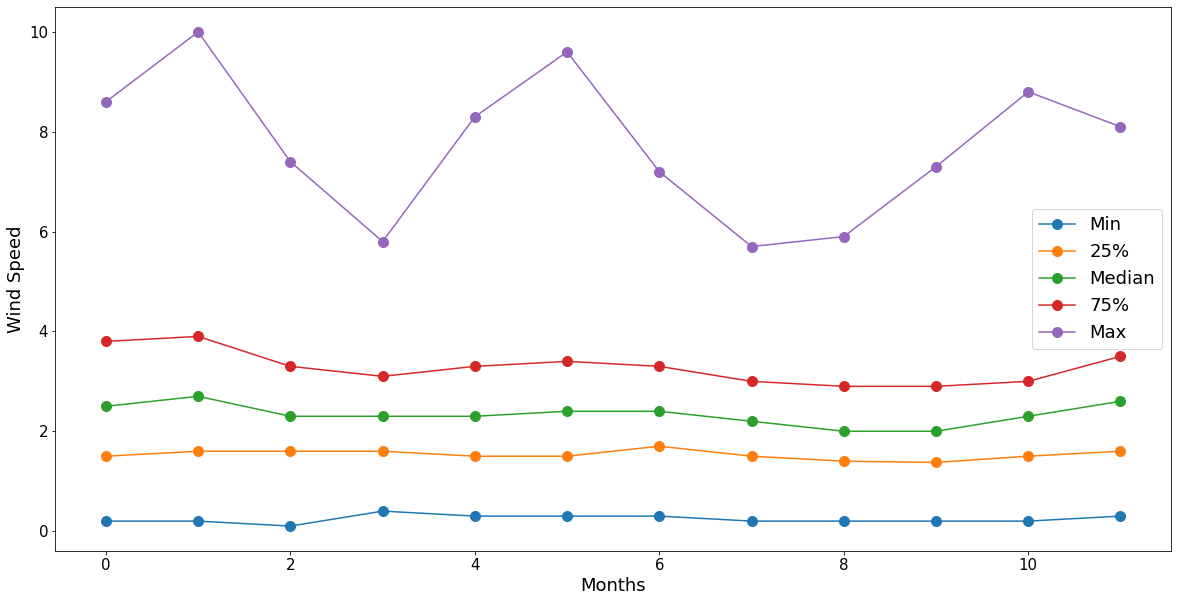

In [ ]:
stats = plot_statistics_over_time(
    data, feature='Wind Speed', dt='monthly', 
    statistics=[
        (np.min, 'Min'),
        (partial(np.percentile, q=25), '25%'), 
        (partial(np.percentile, q=50), 'Median'),
        (partial(np.percentile, q=75), '75%'),
        (np.max, 'Max'),
    ]
)

As I explored this data, I was intrigued at how similar it is in fashion to the data we get in the weather app on our mobile devices. Inspired, I decided to implement a "dashboard" to visualize some relevant features together in one place. 

In [ ]:
def dashboard(data):
    data = data.sort_values(by=['Year', 'Month', 'Day', 'Hour', 'Minute'])

    fig = plt.figure(constrained_layout=True, figsize=(15, 10))
    gs = fig.add_gridspec(5, 3)
    ax1 = fig.add_subplot(gs[:2, :])
    ax2 = fig.add_subplot(gs[2, :-1])
    ax3 = fig.add_subplot(gs[2:, -1])
    ax4 = fig.add_subplot(gs[-2:, 0])
    ax5 = fig.add_subplot(gs[-2:, -2], projection='polar')


    scatter = ax1.scatter(range(data.shape[0]), data['Temperature'], c=data['Solar Zenith Angle'] < 90)
    patches, __ = scatter.legend_elements(num=1)
    legend1 = ax1.legend(
        patches, ["< 90$\degree$", "$\geq 90\degree$"],
        loc="upper right", title="Solar Zenith Angle", fontsize=18, title_fontsize=18, markerscale=1.5)
    ax1.add_artist(legend1)  

    ticks = ax1.get_xticks()
    ticks = [t for t in ticks if t >=0 and t < data.shape[0]]
    _ = ax1.set_xticks(ticks)
    _ = ax1.set_xticklabels(
        [f'{int(r["Hour"]):02d}:{int(r["Minute"]):02d}' for __, r in data.iloc[ticks].iterrows()],
    )
    _ = ax1.set_ylabel("Temperature ($\degree$C)", size=15)
    _ = ax1.tick_params(labelsize=13)

    _ = ax2.boxplot(data['Ozone'], vert=False, widths=0.5)
    _ = ax2.set_yticks([])
    _ = ax2.tick_params(left=False, right=False, top=False)
    _ = ax2.spines['right'].set_visible(False)
    _ = ax2.spines['left'].set_visible(False) 
    _ = ax2.spines['top'].set_visible(False) 
    _ = ax2.set_xlabel("Ozone", size=15)
    _ = ax2.tick_params(labelsize=13)

    cloud_types = ['Clear', 'Probably Clear', 'Fog Water', 'Super-Cooled Water', 'Mixed', 'Opaque Ice', 'Cirrus', 'Overlapping', 'Overshooting', 'Unknown', 'Dust', 'Smoke']
    cloud_info = data["Cloud Type"].value_counts().sort_values(ascending=False)
    _ = ax3.barh(range(cloud_info.shape[0])[::-1], cloud_info / cloud_info.sum() * 100, height=0.75, tick_label=[cloud_types[ind] if ind <= 11 else 'Unknown' for ind in cloud_info.index], edgecolor='Black')
    _ = ax3.set_title("Cloud Types", size=15)
    _ = ax3.set_xlabel("% of Day", size=15)
    _ = ax3.tick_params(labelsize=13)


    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'Above horizon', 'Below Horizon'
    sizes = [sum(data['Solar Zenith Angle'] < 90) / data.shape[0] * 100, sum(data['Solar Zenith Angle'] >= 90) / data.shape[0] * 100]
    explode = (0, 0)

    ax4.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, textprops={'fontsize':13}, colors=['C1', 'C0'])
    ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax4.set_title("Sun Position", size=15)

    ax5.bar(x=data['Wind Direction'] * np.pi/180, height=data['Wind Speed'], width=np.pi/50)
    ax5.set_theta_zero_location('N')
    ax5.set_theta_direction(-1)
    ax5.set_xticklabels(['', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    ax5.set_title("Wind", size=15)
    _ = ax5.tick_params(labelsize=13)

Let's see what the dashboard shows for July 12, 2020 (my birthday!)

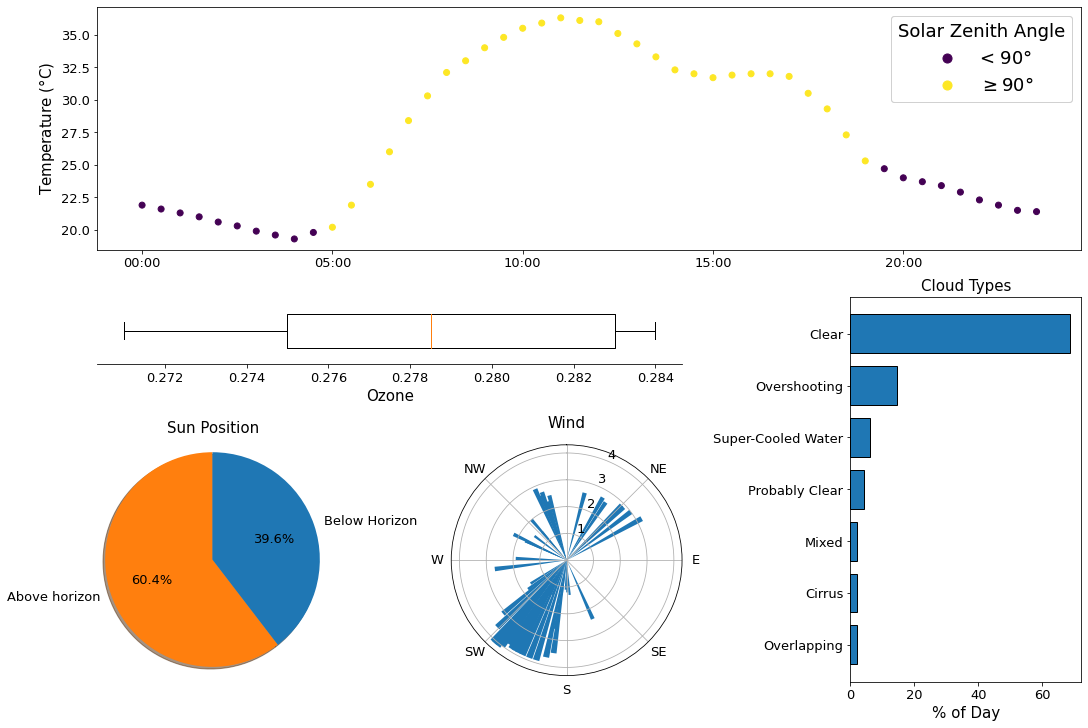

In [ ]:
dashboard(data_by_day.get_group((7, 12)))

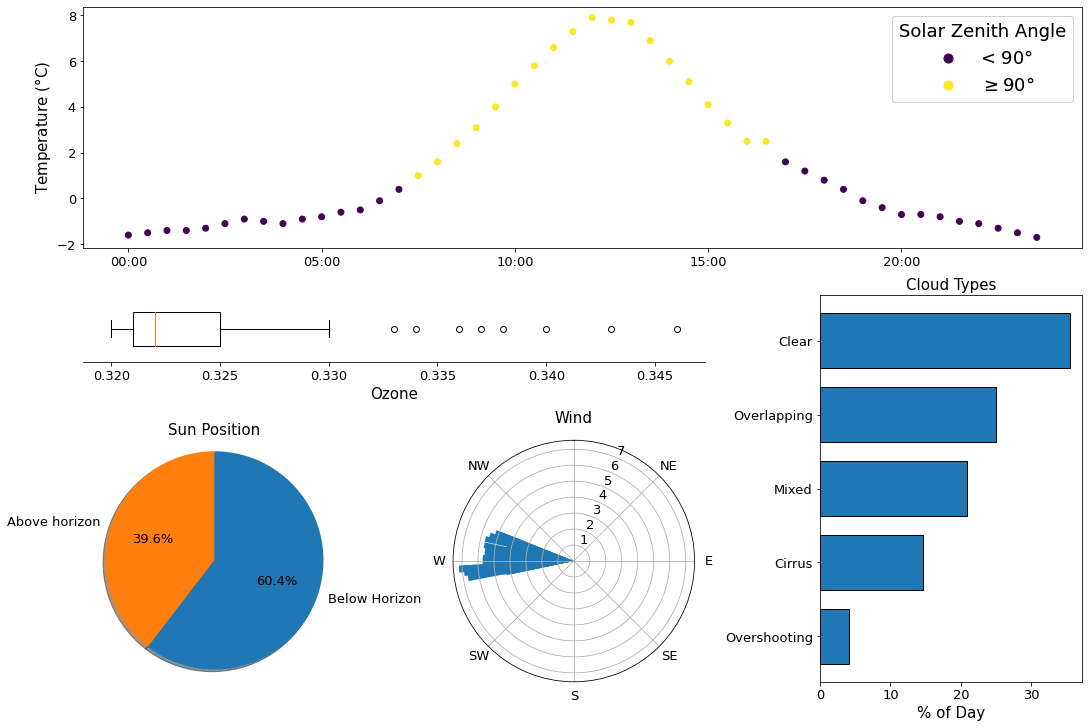

In [ ]:
dashboard(data_by_day.get_group((1, 1)))

Another way I wanted to visualize the data is a color plot as a function of time. Specifically, I wanted to illustrate a particular features values as colors in a plot where the time increases to the right.

In [ ]:
def year_in_color(data, feature):
    _ = plt.figure(figsize=(20, 10))
    _ = plt.imshow([data[feature].values], aspect='auto')
    _ = plt.yticks([])
    ticks, __ = plt.xticks()
    _ = plt.xticks(
        ticks=ticks[1:-1], 
        labels=[f'{int(r["Month"]):02d}/{int(r["Day"]):02d}/{int(r["Year"]):02d}' for __, r in data.iloc[ticks[1:-1]].iterrows()],
        size=15,
        rotation=25
    )
    _ = cbar = plt.colorbar()
    _ = cbar.ax.tick_params(labelsize=15) 
    _ = cbar.ax.set_ylabel(feature, fontsize=20)

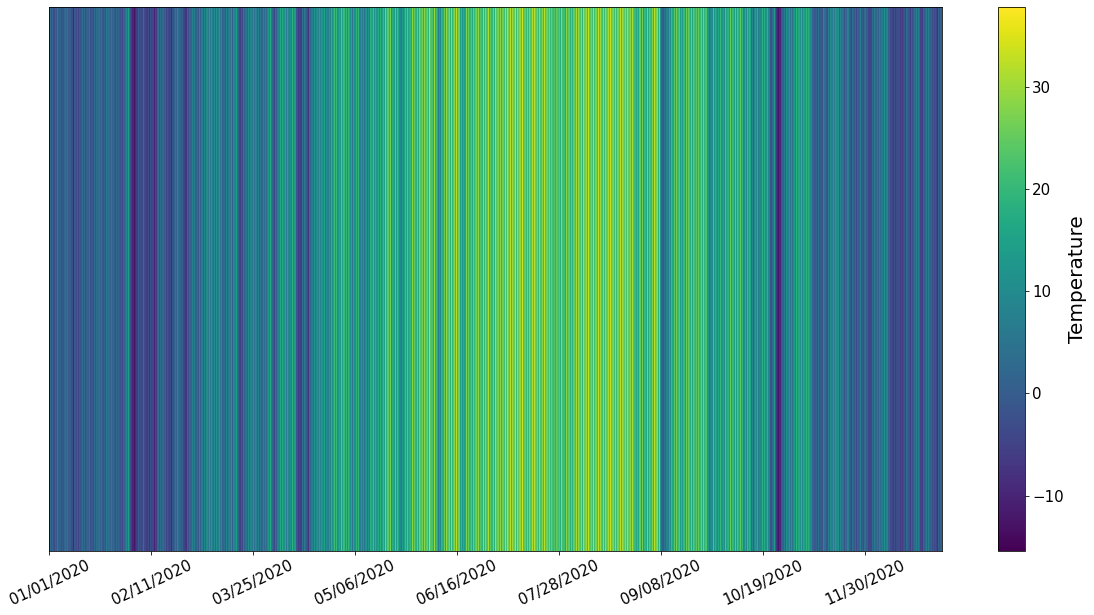

In [ ]:
year_in_color(data, feature='Temperature')

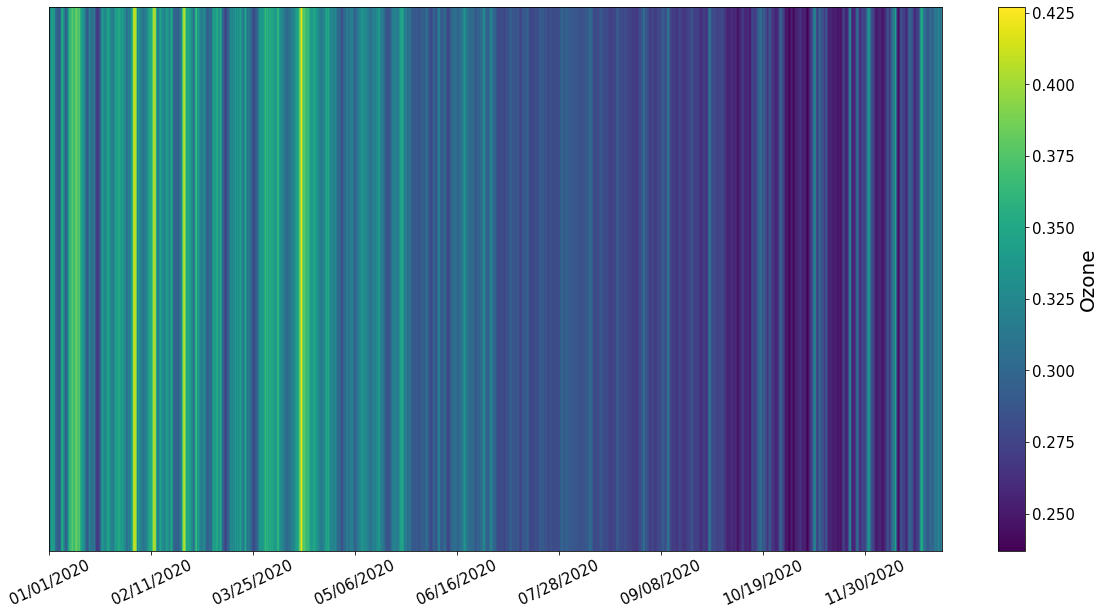

In [ ]:
year_in_color(data, feature='Ozone')

Finally, as I was exploring the NSRDB API website, I found a type of plot that I have never seen before called the 12x14 plot. I really liked how it helped visualize the data, so I implemented my version of it as well.

In [ ]:
def twelve_by_twentyfour(data, feature, statistic=None):
    if statistic is None:
        statistic = (np.mean, 'Mean')

    stat, s_name = statistic

    data = data.sort_values(by=['Year', 'Month', 'Day', 'Hour', 'Minute'])
    agg = data.groupby(["Month", "Hour", "Minute"])
    m = np.array([stat(g[feature]) for __, g in agg]).reshape(12, -1)


    _ = plt.figure(figsize=(20, 10))
    _ = plt.imshow(m, aspect='auto', interpolation=None, extent=(0, 24, 12, 0))
    _ = plt.ylabel("Month", size=15)
    _ = plt.xlabel("Hour", size=15)
    _ = plt.xticks(size=15)
    _ = plt.yticks(size=15)
    _ = cbar = plt.colorbar()
    _ = cbar.ax.tick_params(labelsize=15) 
    _ = cbar.ax.set_ylabel(feature, fontsize=20)
    _ = plt.title(f"12x24 {feature} ({s_name})", size=20)

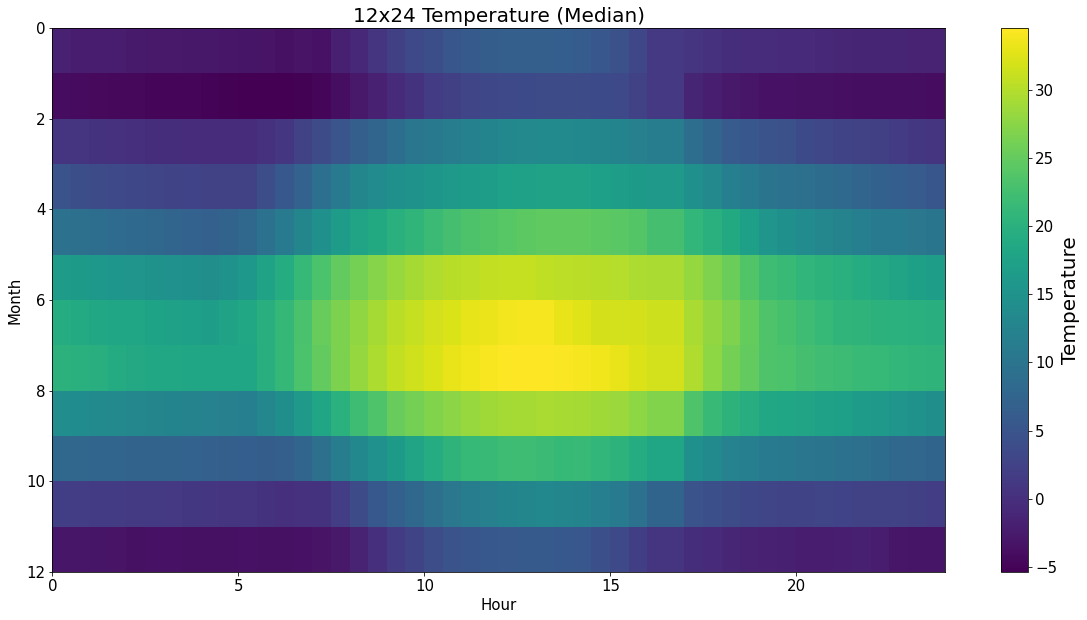

In [ ]:
twelve_by_twentyfour(data, feature='Temperature', statistic=(np.median, 'Median'))

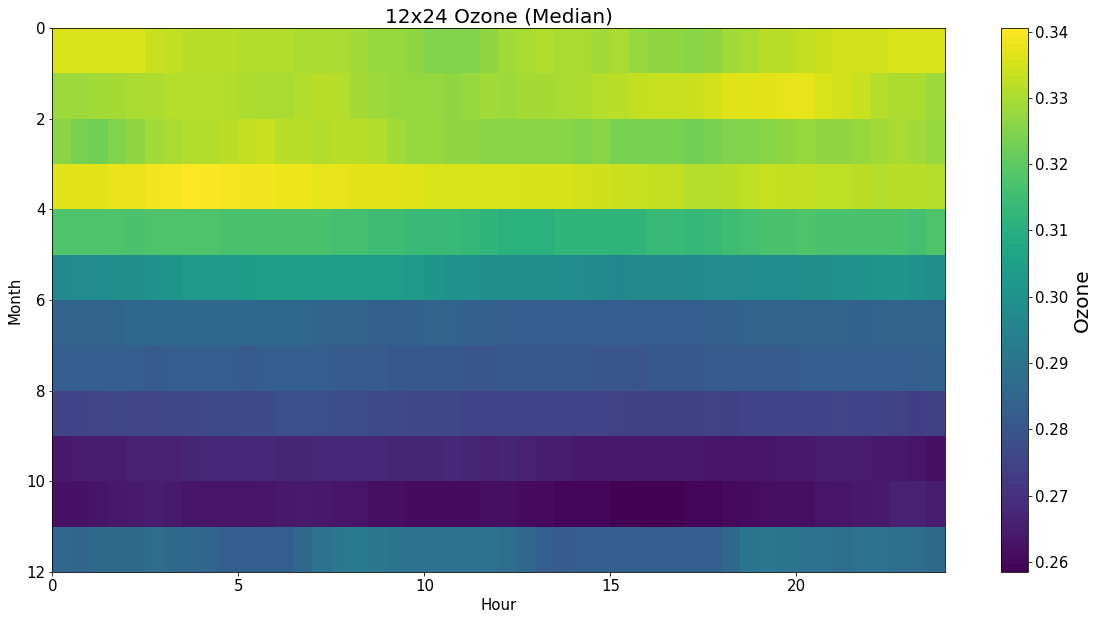

In [ ]:
twelve_by_twentyfour(data, feature='Ozone', statistic=(np.median, 'Median'))

# Machine Learning

Now that we can visualize our data, let's see if we can apply some basic machine learning techniques.

## Temperature Prediction

The easiest question to start with is probably "Can we predict the temperature at a location given the available data features?" This may not be the most useful question to answer, since the model would need a measurement of many  features such as GHI, DHI, Ozone, Wind Speed, etc, in order to make a prediction on the temperature (at that point, just bring a thermometer to your measurement site and save yourself the hassle!). However, we can readily apply ML techniques to answer this question, so it is an easy place to start (Besides, what if your sensors are located in a remote place and the thermometer happened to break before your observation period ended? Just saying).

We will answer this question by training a simple Neural Network on the 17,000+ available data points. First, we split the data into training, validation, and test sets, build the model, and finally train and evaluate it on the data.

In [ ]:
train_size = int(data.shape[0] * 0.7)
valid_size = int(data.shape[0] * 0.2)
test_size = data.shape[0] - train_size - valid_size
data_for_train = data[['Month', 'Day', 'Hour', 'Minute', 'GHI', 'DHI', 'DNI', 'Solar Zenith Angle', 'Ozone', 'Wind Speed', 'Wind Direction', 'Temperature']].values
np.random.seed(42)
np.random.shuffle(data_for_train)

In [ ]:
X_train = data_for_train[:train_size, :-1]
X_valid = data_for_train[train_size:train_size+valid_size, :-1]
X_test = data_for_train[train_size+valid_size:, :-1]
Y_train = data_for_train[:train_size, -1]
Y_valid = data_for_train[train_size:train_size+valid_size, -1]
Y_test = data_for_train[train_size+valid_size:, -1]

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(300, activation='relu', input_shape=[11]))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation=None))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

In [ ]:
model.fit(X_train_s, Y_train, epochs=50, validation_data=(scaler.transform(X_valid), Y_valid), shuffle=True, batch_size=10)

Epoch 1/50
1227/1227 [==============================] - 3s 2ms/step - loss: 22.3959 - val_loss: 13.5622
Epoch 2/50
1227/1227 [==============================] - 2s 2ms/step - loss: 14.2880 - val_loss: 12.9816
Epoch 3/50
1227/1227 [==============================] - 2s 2ms/step - loss: 12.9714 - val_loss: 12.6356
Epoch 4/50
1227/1227 [==============================] - 2s 2ms/step - loss: 11.7620 - val_loss: 12.4264
Epoch 5/50
1227/1227 [==============================] - 2s 2ms/step - loss: 10.9312 - val_loss: 10.4219
Epoch 6/50
1227/1227 [==============================] - 2s 2ms/step - loss: 10.1288 - val_loss: 9.6065
Epoch 7/50
1227/1227 [==============================] - 2s 2ms/step - loss: 9.8802 - val_loss: 9.1269
Epoch 8/50
1227/1227 [==============================] - 2s 2ms/step - loss: 9.2525 - val_loss: 9.1572
Epoch 9/50
1227/1227 [==============================] - 2s 2ms/step - loss: 8.5803 - val_loss: 10.1554
Epoch 10/50
1227/1227 [==============================] - 2s 2ms/step -

In [ ]:
model.save("temperature_NN.h5")

In [ ]:
model = tf.keras.models.load_model("temperature_NN.h5")

To evaulate our model performance, let's look at the plot of predicted temperatures as a function of the measured temperatures for our validation and test sets.

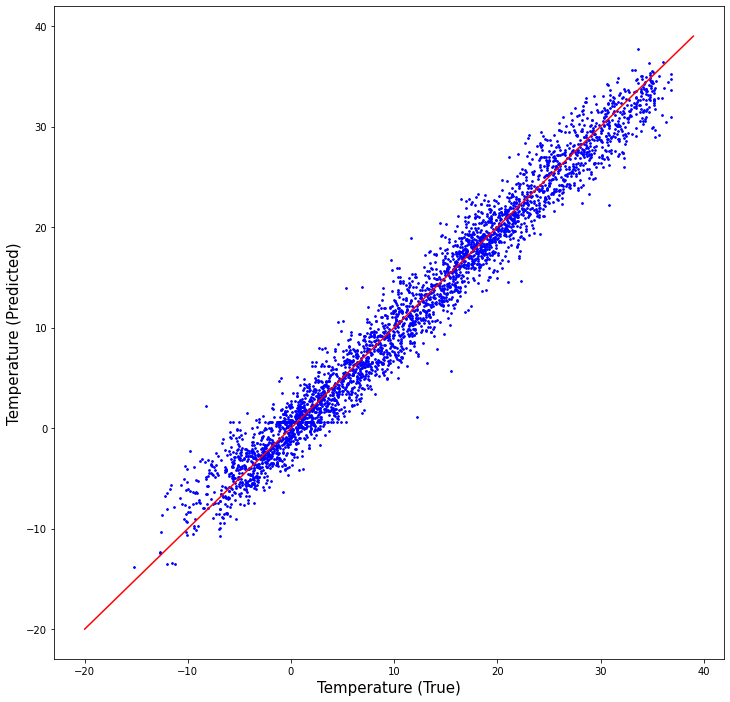

In [ ]:
Y_valid_pred = model.predict(scaler.transform(X_valid)).flatten()
_ = plt.figure(figsize=(12, 12))
_ = plt.scatter(Y_valid, Y_valid_pred, marker='o', color='blue', s=3)
_ = plt.plot(range(-20, 40), range(-20, 40), color='red')
_ = plt.xlabel("Temperature (True)", size=15)
_ = plt.ylabel("Temperature (Predicted)", size=15)

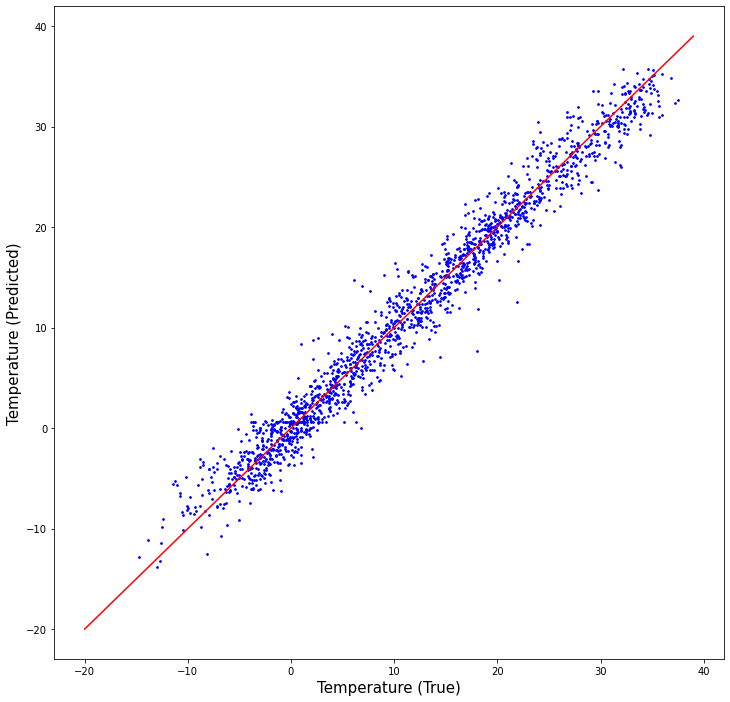

In [ ]:
Y_test_pred = model.predict(scaler.transform(X_test)).flatten()
_ = plt.figure(figsize=(12, 12))
_ = plt.scatter(Y_test, Y_test_pred, marker='o', color='blue', s=3)
_ = plt.plot(range(-20, 40), range(-20, 40), color='red')
_ = plt.xlabel("Temperature (True)", size=15)
_ = plt.ylabel("Temperature (Predicted)", size=15)

In [ ]:
compare = pd.DataFrame(data={'true': Y_test, 'pred': Y_test_pred})
((compare['pred'] + 20) / (compare['true'] + 20)).describe()

count    1752.000000
mean        1.006789
std         0.089799
min         0.627074
25%         0.960560
50%         0.996812
75%         1.041013
max         1.677218
dtype: float64

As we can see, on average, our termperature model predicts the temperature correctly to within 1%. In fact, we get the correct answer to within 4% for 3/4 of the data! However, we do also see some outliers, and our predictions can be off by over 67% in rare cases.

Keep in mind that this was a rather simple model and can likely be improved by adding more data and/or making the network more complex.

## Temperature Forecasting

A slightly more interesting problem would be to predict the future temperature given a set of past measurements. To tackle this one, let's implement a highly simplified WaveNet.

In [ ]:
def shape_data_into_overlapping_time_series(data, n_steps):
    n_batches = (data.shape[0] - n_steps) // 48
    out = np.empty((n_batches, n_steps, 1 if len(data.shape) == 1 else data.shape[1]))
    for ind in range(n_batches):
        out[ind, :, :] = data[ind*48:ind*48 + n_steps].reshape(out.shape[1], out.shape[2])
    return out

In [ ]:
scaler = StandardScaler()
temps = shape_data_into_overlapping_time_series(scaler.fit_transform(data['Temperature'].values.reshape(-1, 1)), 192)
np.random.seed(42)
np.random.shuffle(temps)
train_size = int(temps.shape[0] * 0.7)
valid_size = int(temps.shape[0] * 0.2)
test_size = temps.shape[0] - train_size - valid_size

In [ ]:
X_train = temps[:train_size, :48*3]
X_valid = temps[train_size:train_size+valid_size, :48*3]
X_test = temps[train_size+valid_size:, :48*3]

In [ ]:
Y = np.empty((temps.shape[0], 48*3, 48))
for step_ahead in range(1, 48 + 1):
    Y[:, :, step_ahead-1] = temps[:, step_ahead:step_ahead+48*3, 0]
Y_train = Y[:train_size]
Y_valid = Y[train_size:train_size+valid_size]
Y_test = Y[train_size+valid_size:]

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, X_train.shape[-1]]))
for rate in (1, 2, 4, 8) * 2:
    model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))
model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=1))

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1] * scaler.scale_[0] + scaler.mean_[0], Y_pred[:, -1] * scaler.scale_[0] + scaler.mean_[0])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), shuffle=True)

Epoch 1/100
8/8 [==============================] - 2s 77ms/step - loss: 0.8867 - last_time_step_mse: 118.7487 - val_loss: 0.7916 - val_last_time_step_mse: 88.7671
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 0.6019 - last_time_step_mse: 67.3831 - val_loss: 0.4739 - val_last_time_step_mse: 65.8967
Epoch 3/100
8/8 [==============================] - 0s 35ms/step - loss: 0.4312 - last_time_step_mse: 51.1646 - val_loss: 0.3755 - val_last_time_step_mse: 45.1116
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 0.3742 - last_time_step_mse: 42.4564 - val_loss: 0.3232 - val_last_time_step_mse: 37.0623
Epoch 5/100
8/8 [==============================] - 0s 37ms/step - loss: 0.3172 - last_time_step_mse: 33.4045 - val_loss: 0.2719 - val_last_time_step_mse: 29.6562
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 0.2674 - last_time_step_mse: 28.9803 - val_loss: 0.2248 - val_last_time_step_mse: 24.0724
Epoch 7/100
8/8 [==========

In [ ]:
model.save("wavenet_for_temps.h5")

In [ ]:
model = tf.keras.models.load_model("wavenet_for_temps.h5", custom_objects={'last_time_step_mse': last_time_step_mse})

In [ ]:
def last_time_step_mse_n(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1] * scaler.scale_[0] + scaler.mean_[0], Y_pred[:, -1] * scaler.scale_[0] + scaler.mean_[0]).numpy()

errors = last_time_step_mse_n(Y_valid, model.predict(X_valid))
errors.mean()

12.672563

Let's examine some examples from the validation set:

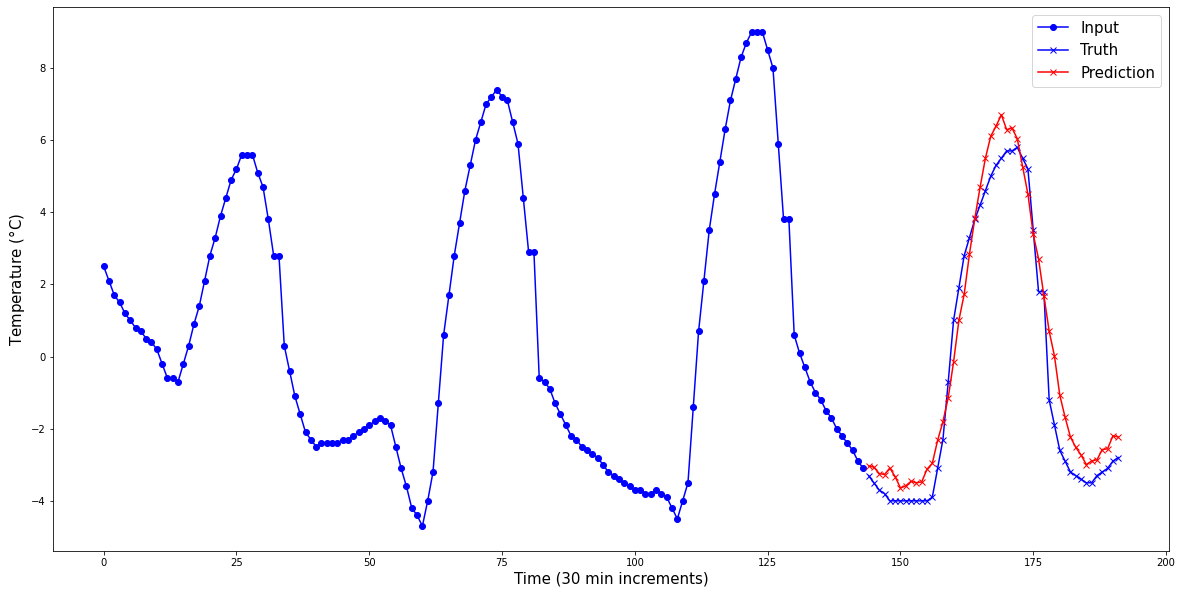

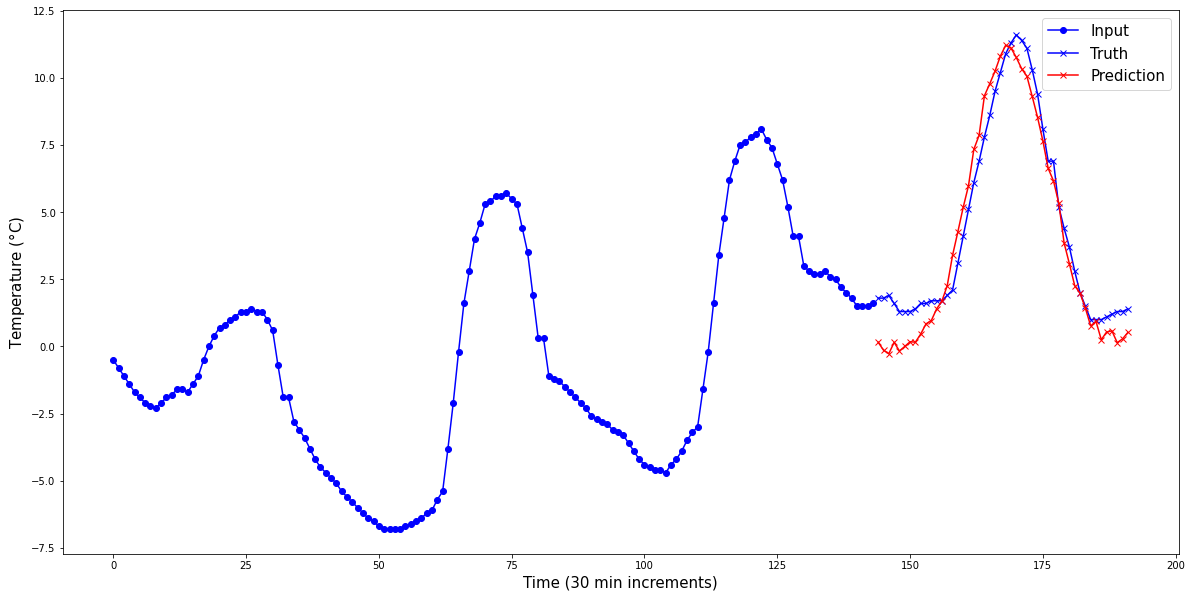

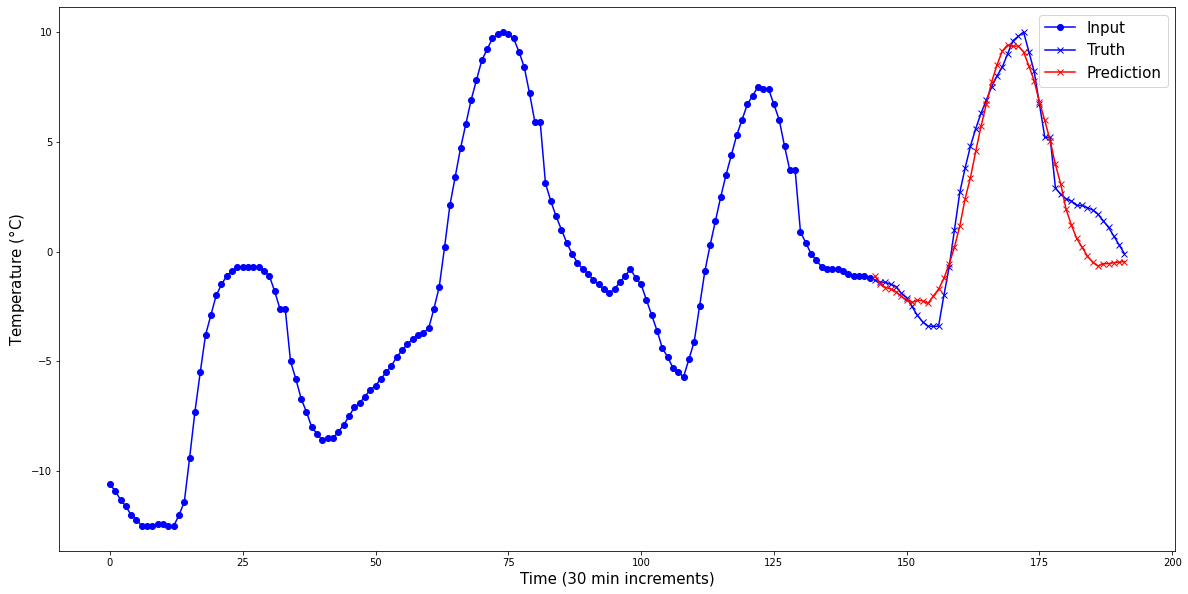

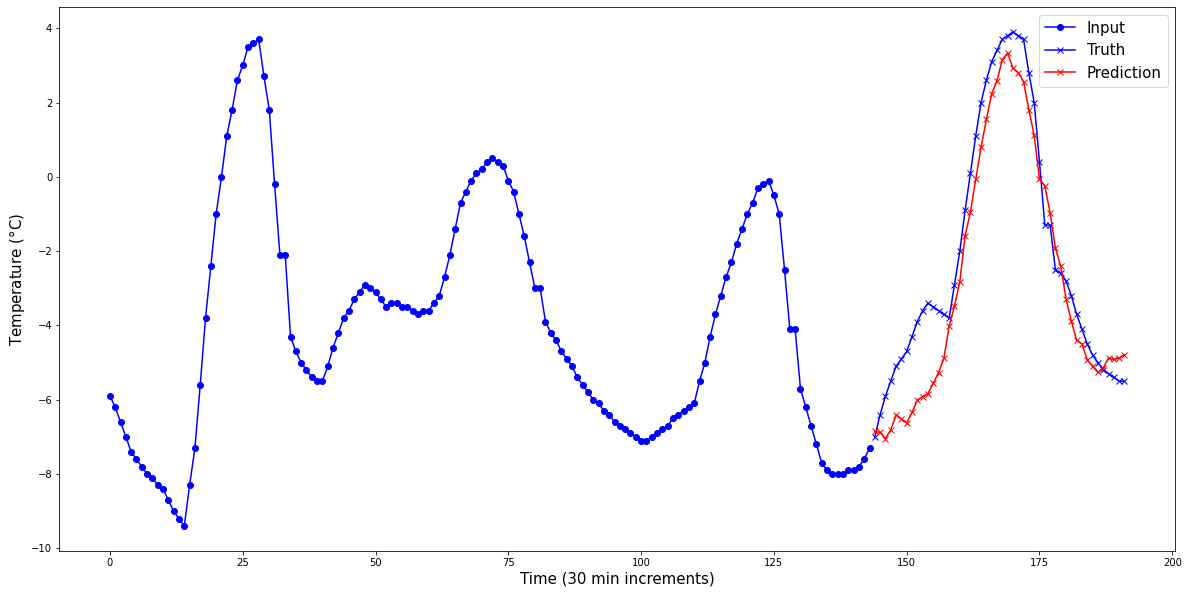

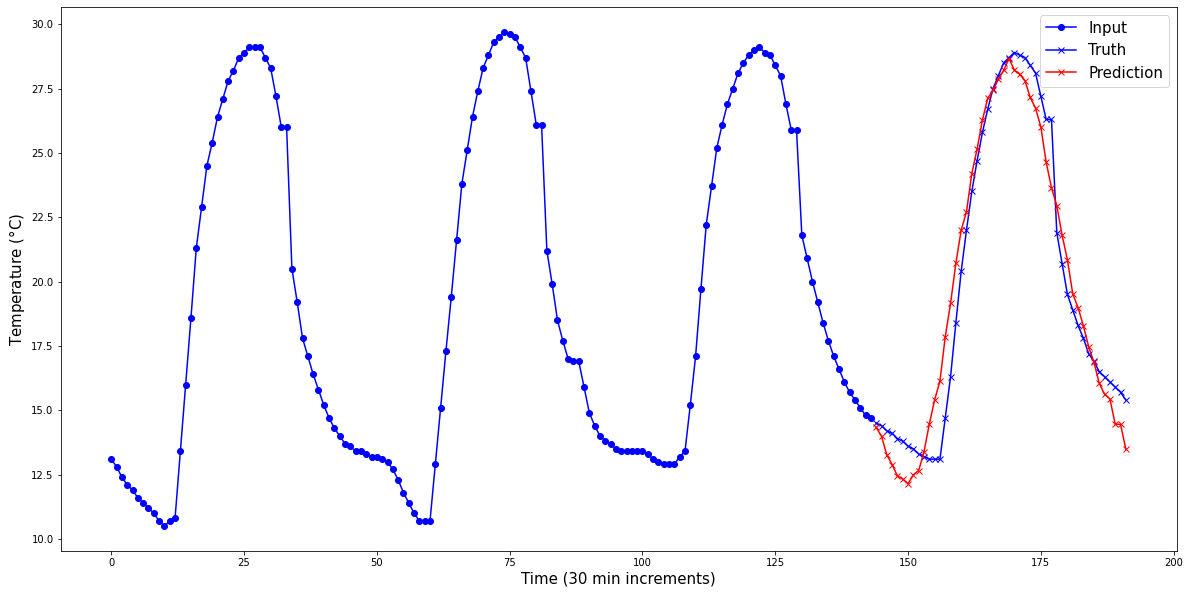

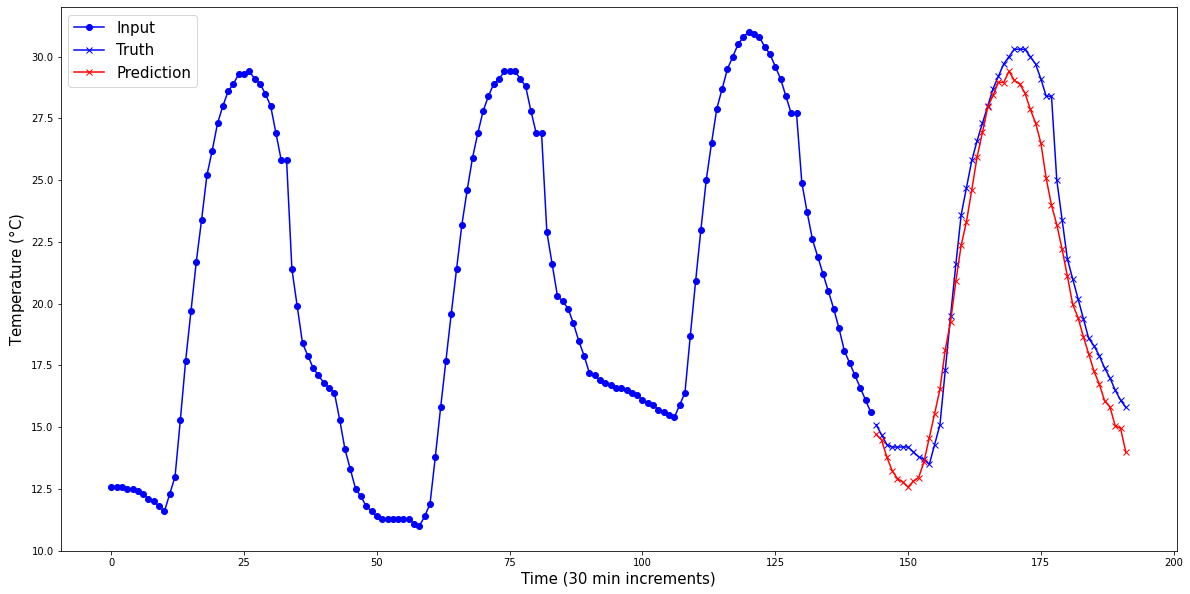

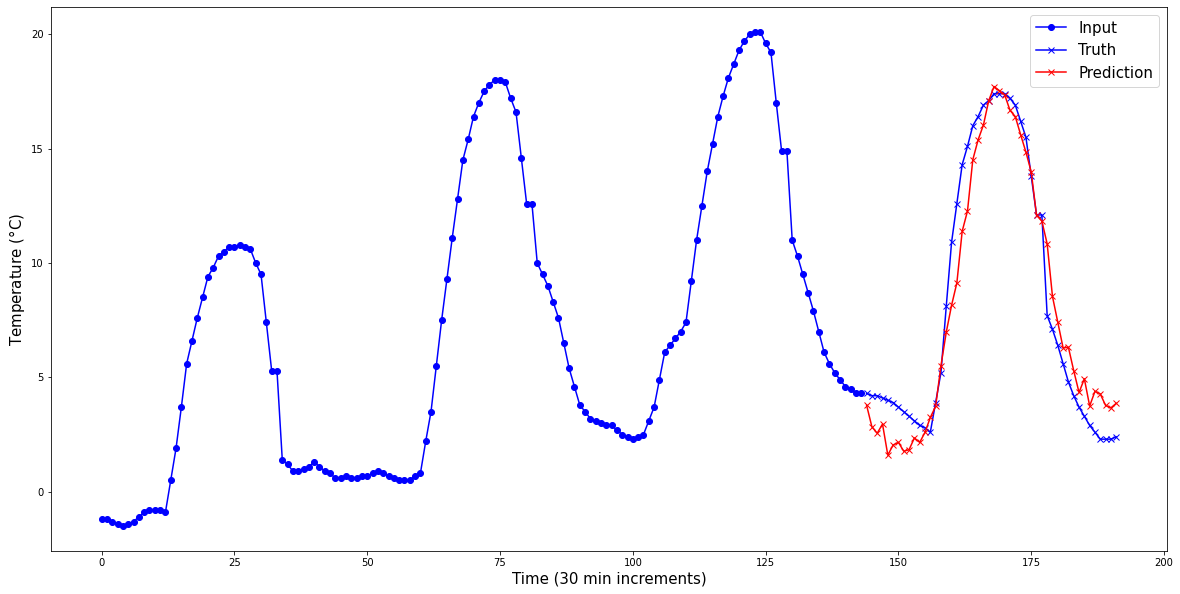

In [ ]:
for batch_to_plot in [36, 42, 47, 71, 35, 50,  1]: 
    _ = plt.figure(figsize=(20, 10))
    _ = plt.plot(range(48*3), X_valid[batch_to_plot, :, 0] * scaler.scale_[0] + scaler.mean_[0], marker='o', color='blue', label='Input')
    _ = plt.plot(range(48*3,48*4), Y_valid[batch_to_plot, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='blue', label='Truth')
    _ = plt.plot(range(48*3,48*4), model.predict(X_valid[batch_to_plot:batch_to_plot+1, :, :])[0, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='red', label='Prediction')
    _ = plt.legend(fontsize=15)
    _ = plt.xlabel("Time (30 min increments)", size=15)
    _ = plt.ylabel("Temperature ($\degree$C)", size=15)
    _ = plt.show()

Not bad! Let's see how we do on the test set:

In [ ]:
def last_time_step_mse_n(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1] * scaler.scale_[0] + scaler.mean_[0], Y_pred[:, -1] * scaler.scale_[0] + scaler.mean_[0]).numpy()

errors = last_time_step_mse_n(Y_test, model.predict(X_test))
errors.mean() 

15.203394

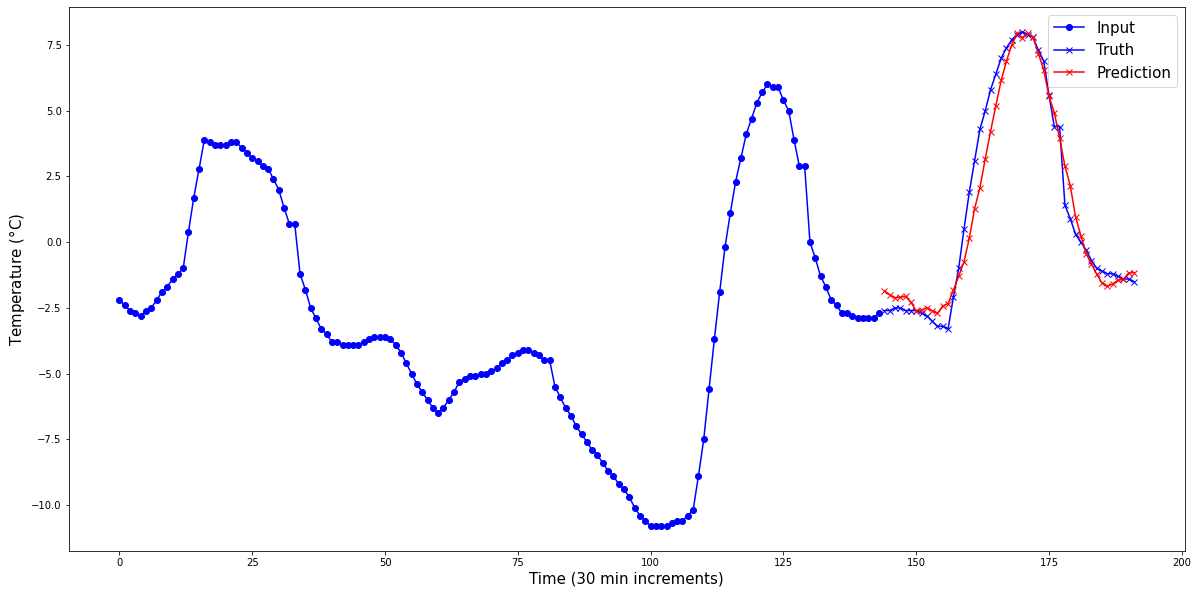

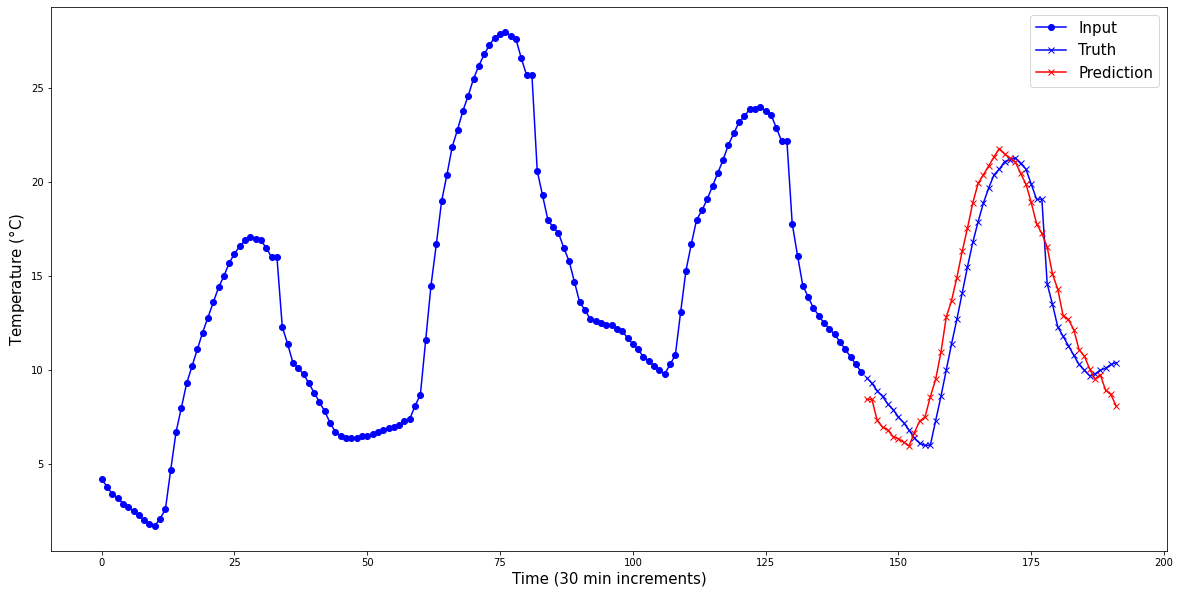

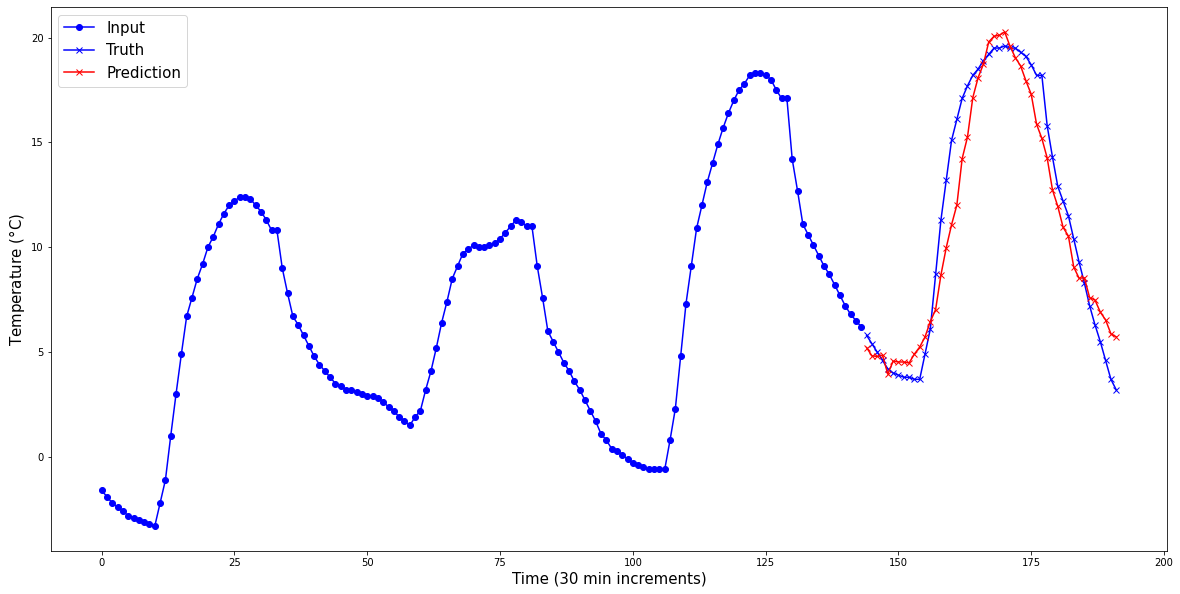

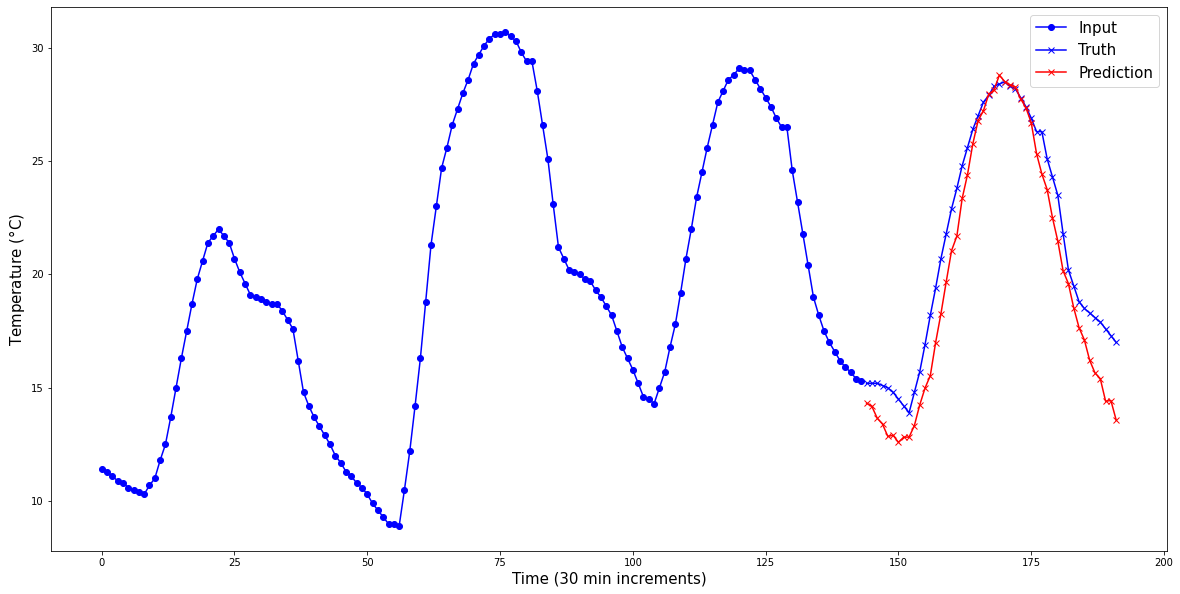

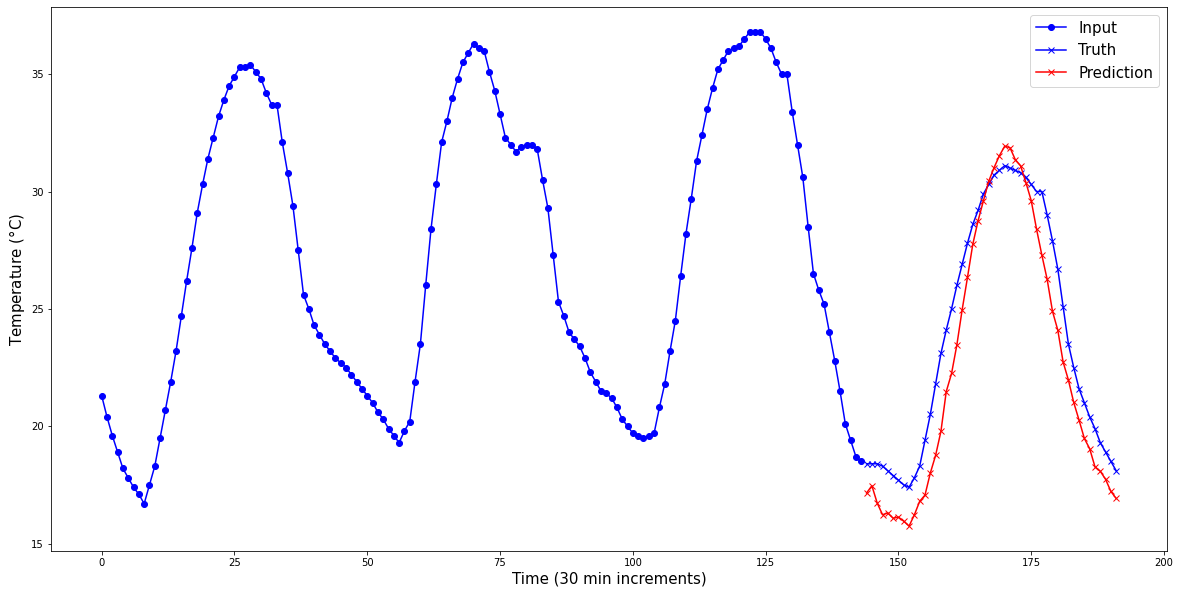

In [ ]:
for batch_to_plot in [2, 34, 25,  8, 17]: 
    _ = plt.figure(figsize=(20, 10))
    _ = plt.plot(range(48*3), X_test[batch_to_plot, :, 0] * scaler.scale_[0] + scaler.mean_[0], marker='o', color='blue', label='Input')
    _ = plt.plot(range(48*3,48*4), Y_test[batch_to_plot, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='blue', label='Truth')
    _ = plt.plot(range(48*3,48*4), model.predict(X_test[batch_to_plot:batch_to_plot+1, :, :])[0, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='red', label='Prediction')
    _ = plt.legend(fontsize=15)
    _ = plt.xlabel("Time (30 min increments)", size=15)
    _ = plt.ylabel("Temperature ($\degree$C)", size=15)
    _ = plt.show()

So far so good, but perhaps we can do better by including not only the temperature measurements as inputs to the model, but also some of the other features, such as GHI and Ozone:

In [ ]:
scaler = StandardScaler()
temps = shape_data_into_overlapping_time_series(scaler.fit_transform(data[['Temperature', 'GHI', 'Ozone']].values), 192)
np.random.seed(42)
np.random.shuffle(temps)
train_size = int(temps.shape[0] * 0.7)
valid_size = int(temps.shape[0] * 0.2)
test_size = temps.shape[0] - train_size - valid_size

In [ ]:
X_train = temps[:train_size, :48*3]
X_valid = temps[train_size:train_size+valid_size, :48*3]
X_test = temps[train_size+valid_size:, :48*3]

In [ ]:
Y = np.empty((temps.shape[0], 48*3, 48))
for step_ahead in range(1, 48 + 1):
    Y[:, :, step_ahead-1] = temps[:, step_ahead:step_ahead+48*3, 0]
Y_train = Y[:train_size]
Y_valid = Y[train_size:train_size+valid_size]
Y_test = Y[train_size+valid_size:]

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, X_train.shape[-1]]))
for rate in (1, 2, 4, 8) * 2:
    model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))
model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=1))

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1] * scaler.scale_[0] + scaler.mean_[0], Y_pred[:, -1] * scaler.scale_[0] + scaler.mean_[0])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), shuffle=True)

Epoch 1/100
8/8 [==============================] - 2s 73ms/step - loss: 0.9238 - last_time_step_mse: 125.3038 - val_loss: 0.8453 - val_last_time_step_mse: 116.5660
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 0.6430 - last_time_step_mse: 86.0959 - val_loss: 0.4877 - val_last_time_step_mse: 66.6141
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 0.4112 - last_time_step_mse: 53.7941 - val_loss: 0.3328 - val_last_time_step_mse: 47.8575
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 0.3195 - last_time_step_mse: 47.2734 - val_loss: 0.2791 - val_last_time_step_mse: 46.1397
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 0.2753 - last_time_step_mse: 45.5888 - val_loss: 0.2276 - val_last_time_step_mse: 37.7328
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 0.2247 - last_time_step_mse: 38.3012 - val_loss: 0.2105 - val_last_time_step_mse: 33.5261
Epoch 7/100
8/8 [=========

In [ ]:
model.save("wavenet_for_temps_ghi_ozone.h5")

In [ ]:
model = tf.keras.models.load_model("wavenet_for_temps_ghi_ozone.h5", custom_objects={'last_time_step_mse': last_time_step_mse})

In [ ]:
def last_time_step_mse_n(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1] * scaler.scale_[0] + scaler.mean_[0], Y_pred[:, -1] * scaler.scale_[0] + scaler.mean_[0]).numpy()

errors = last_time_step_mse_n(Y_valid, model.predict(X_valid))
errors.mean() 

11.963721

Better Validation score than before, so we are onto something! Let's examine some of the predictions:

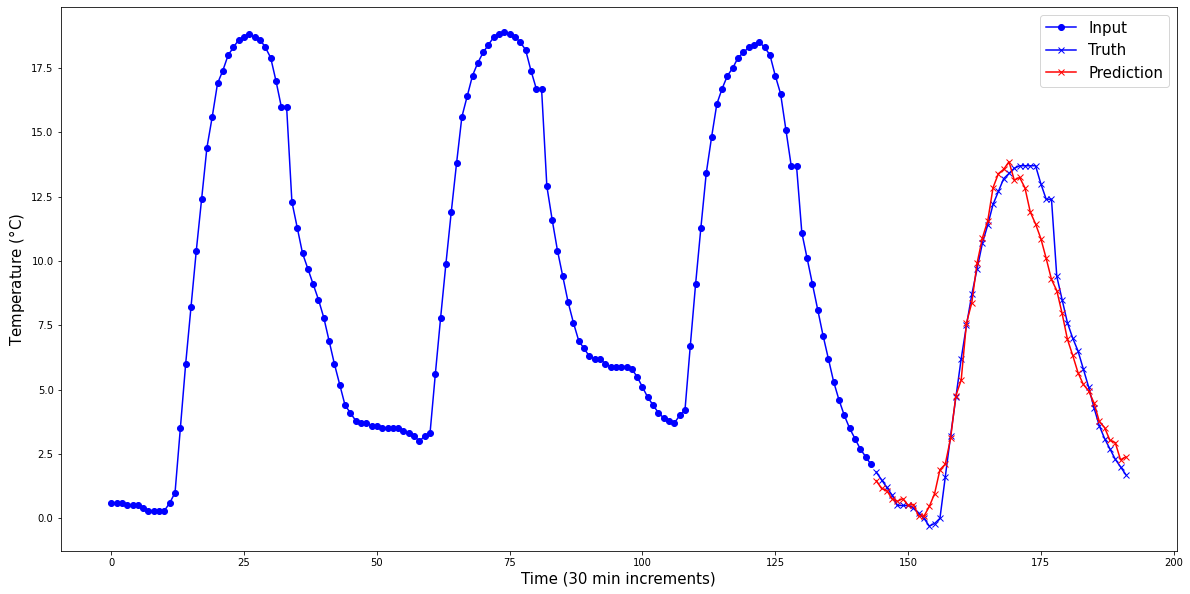

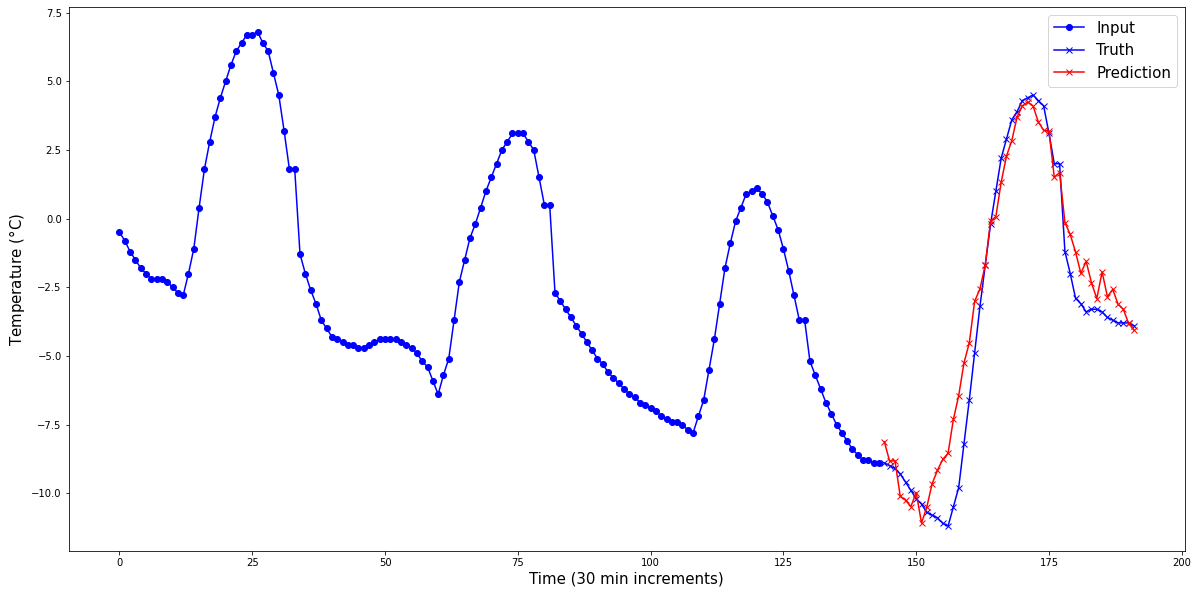

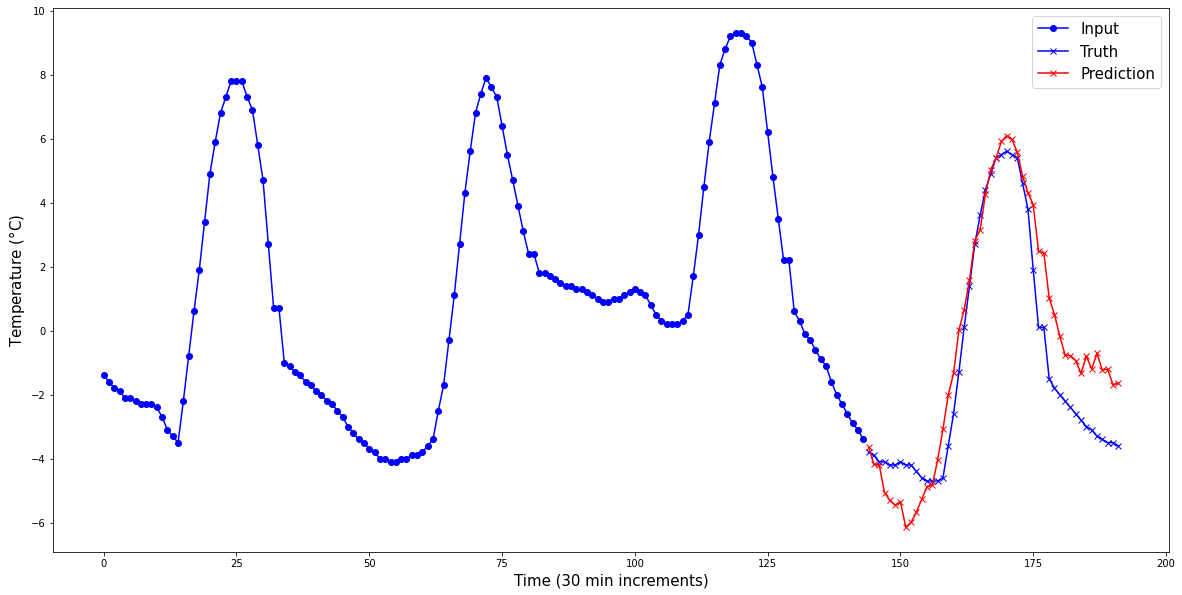

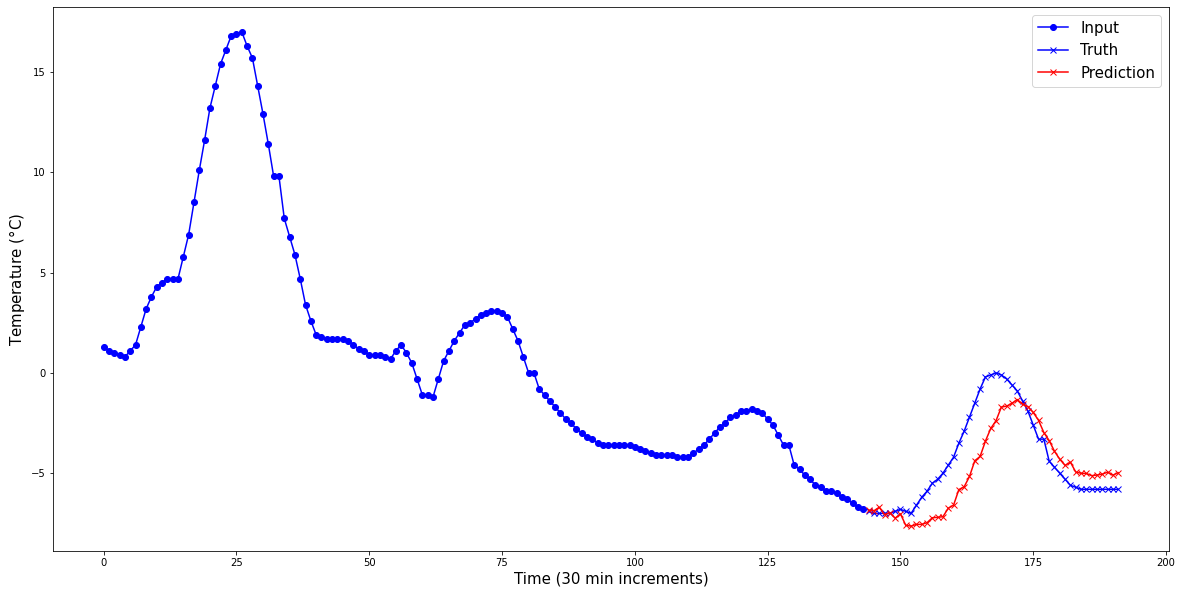

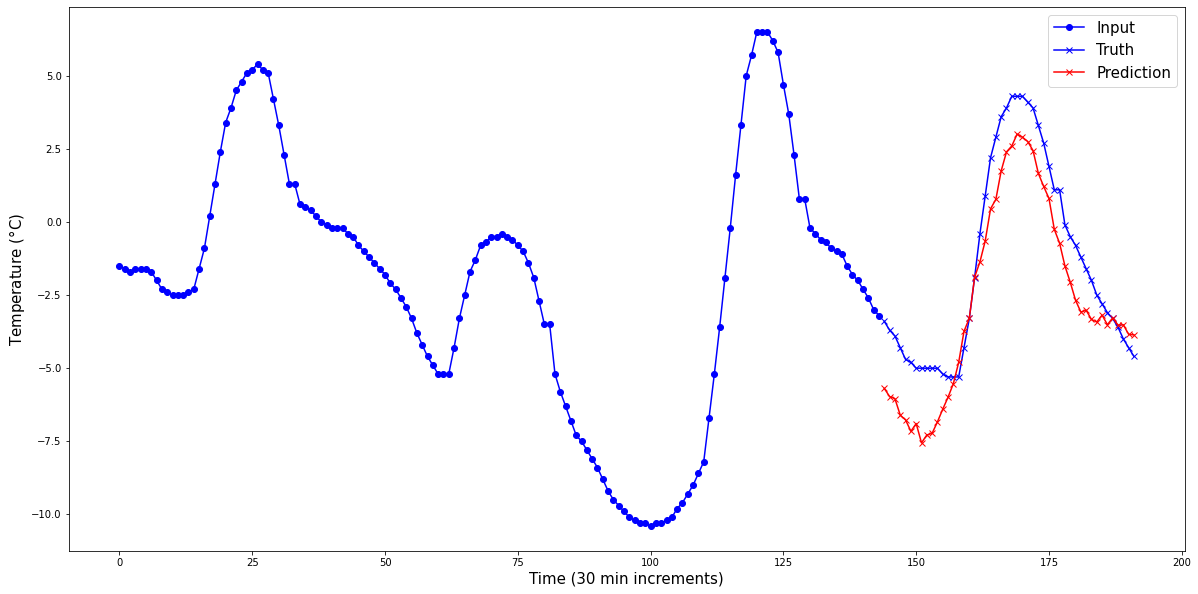

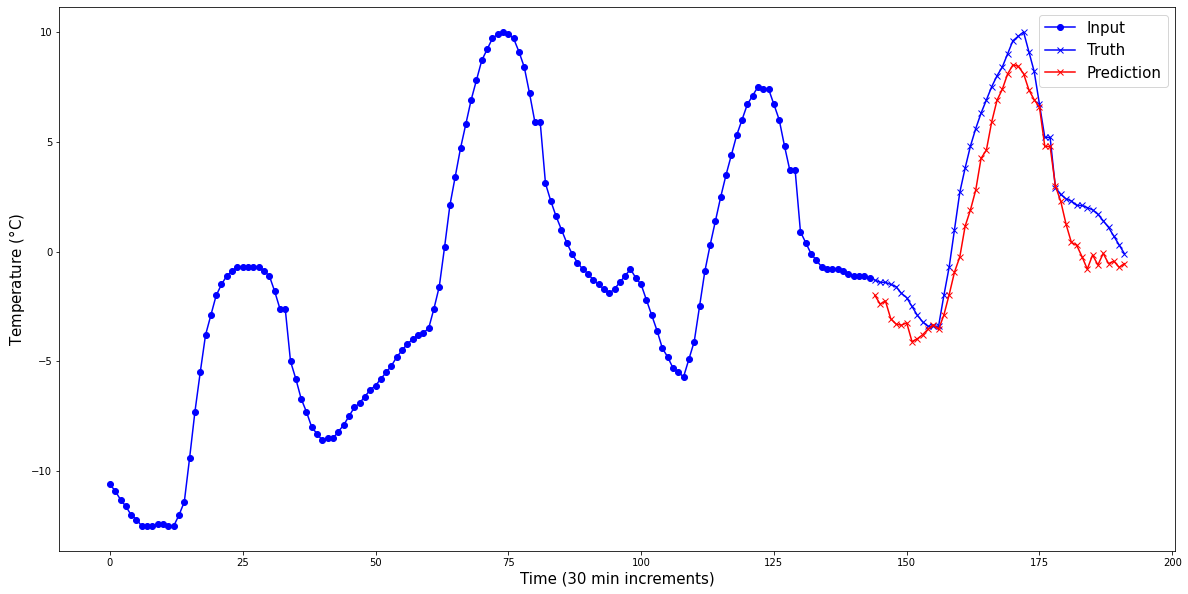

In [ ]:
for batch_to_plot in [28, 13, 29, 33, 27, 47]: 
    _ = plt.figure(figsize=(20, 10))
    _ = plt.plot(range(48*3), X_valid[batch_to_plot, :, 0] * scaler.scale_[0] + scaler.mean_[0], marker='o', color='blue', label='Input')
    _ = plt.plot(range(48*3,48*4), Y_valid[batch_to_plot, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='blue', label='Truth')
    _ = plt.plot(range(48*3,48*4), model.predict(X_valid[batch_to_plot:batch_to_plot+1, :, :])[0, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='red', label='Prediction')
    _ = plt.legend(fontsize=15)
    _ = plt.xlabel("Time (30 min increments)", size=15)
    _ = plt.ylabel("Temperature ($\degree$C)", size=15)
    _ = plt.show()

Not bad! How about the performance on the test set?

In [ ]:
def last_time_step_mse_n(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1] * scaler.scale_[0] + scaler.mean_[0], Y_pred[:, -1] * scaler.scale_[0] + scaler.mean_[0]).numpy()

errors = last_time_step_mse_n(Y_test, model.predict(X_test))
errors.mean() 

10.135771

That is actually quite better than before. Let's look at some examples:

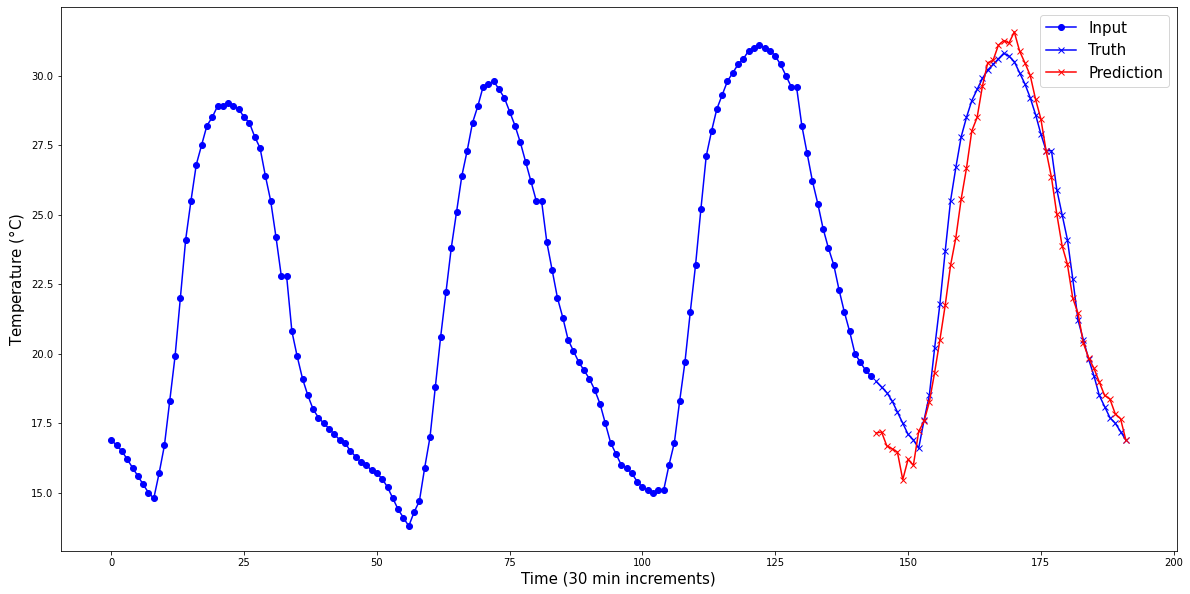

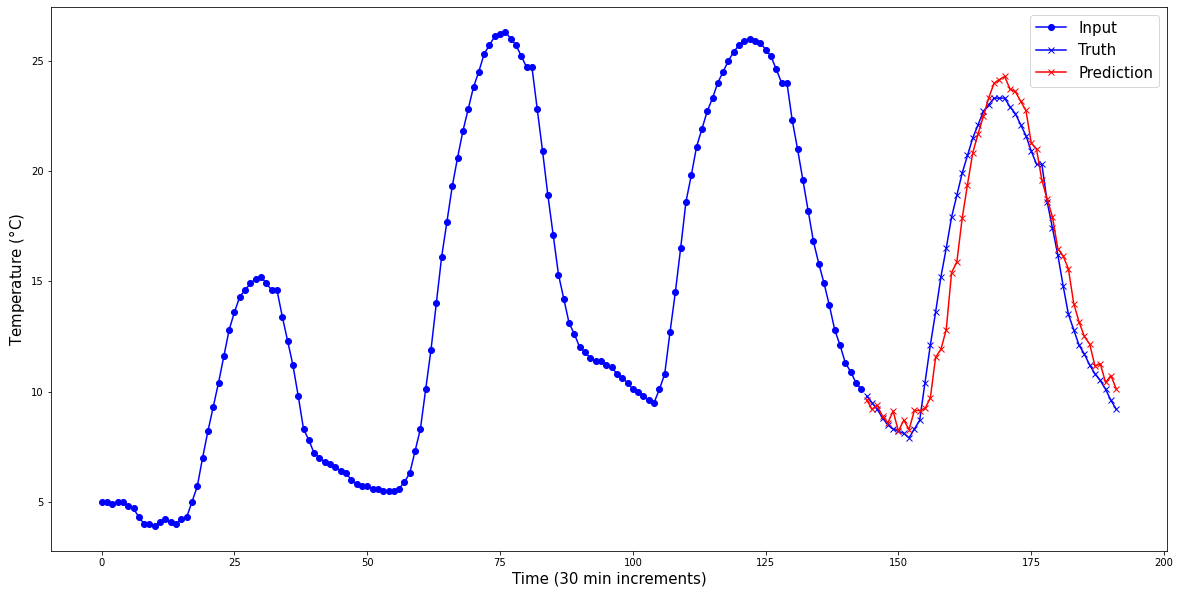

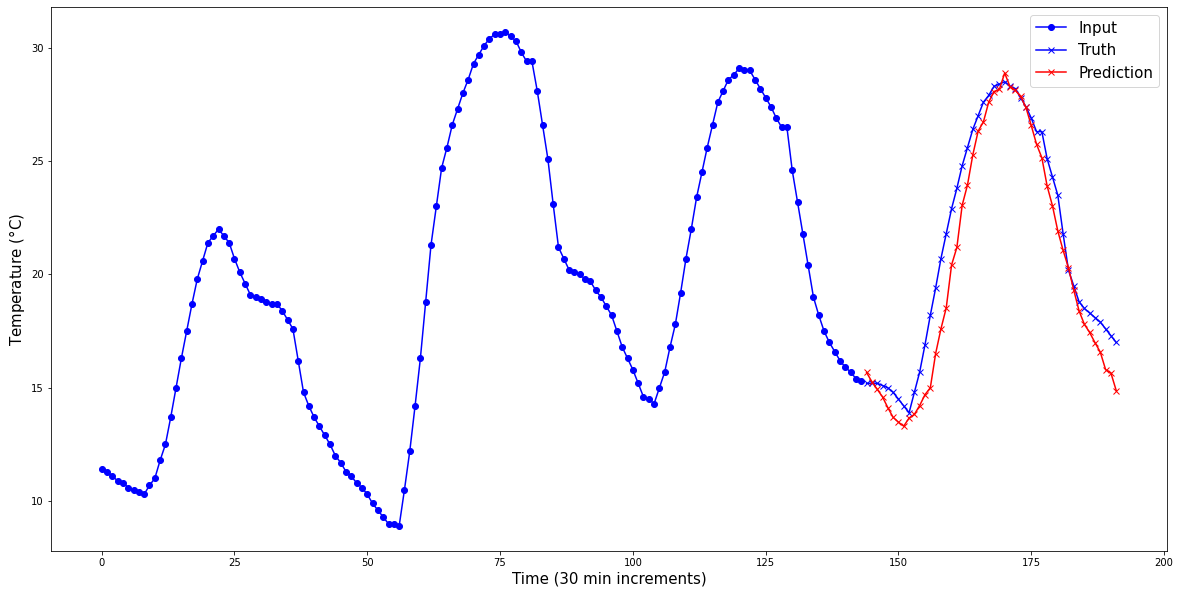

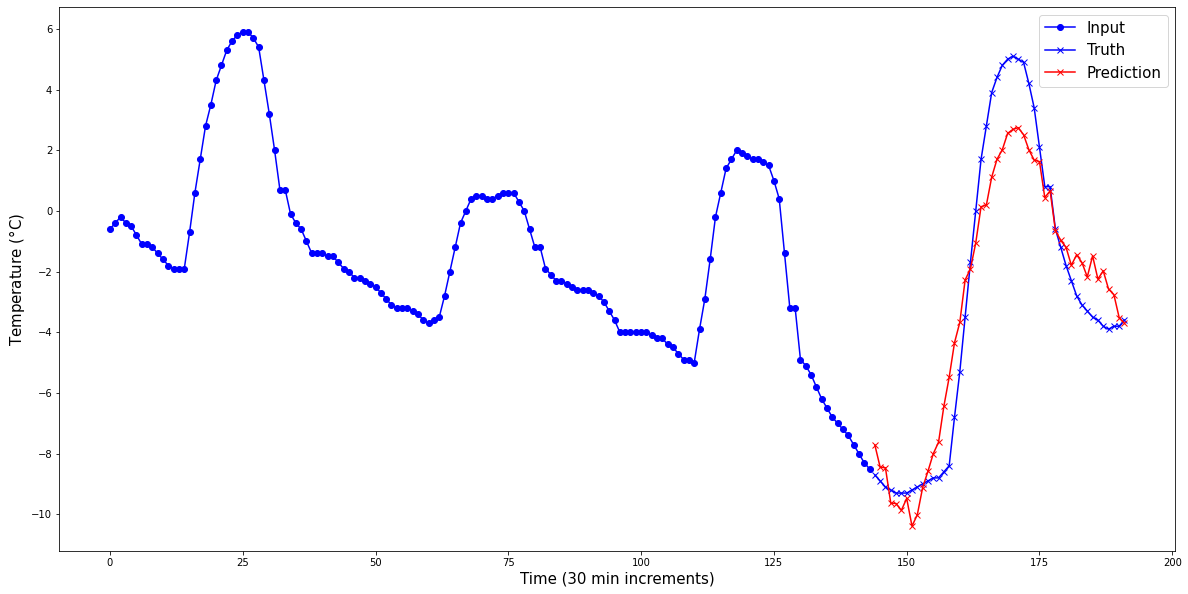

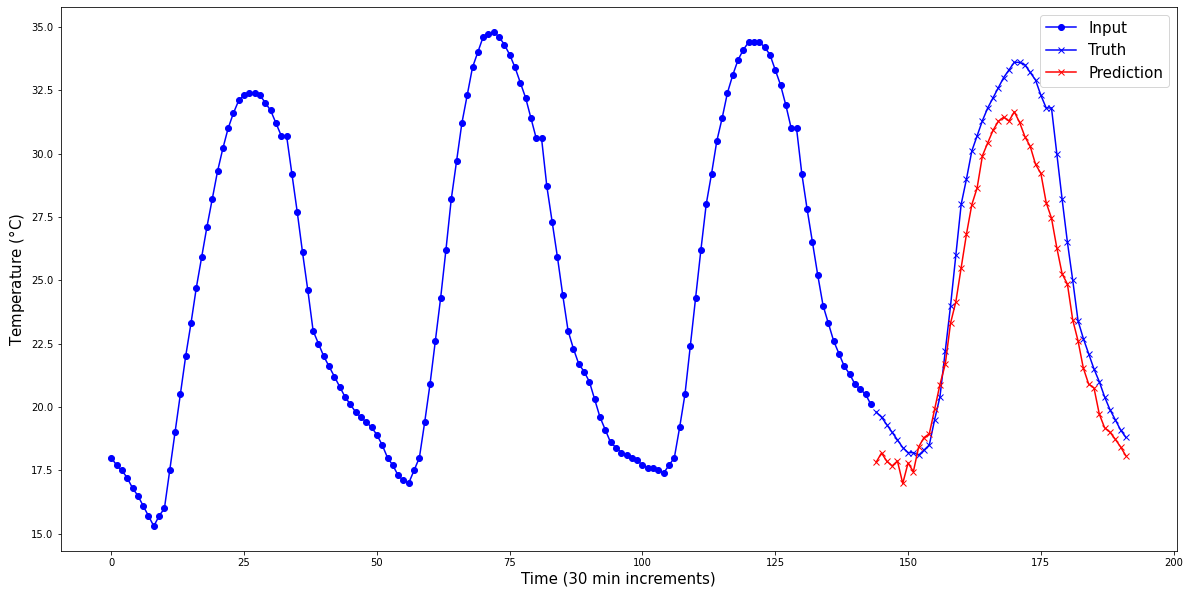

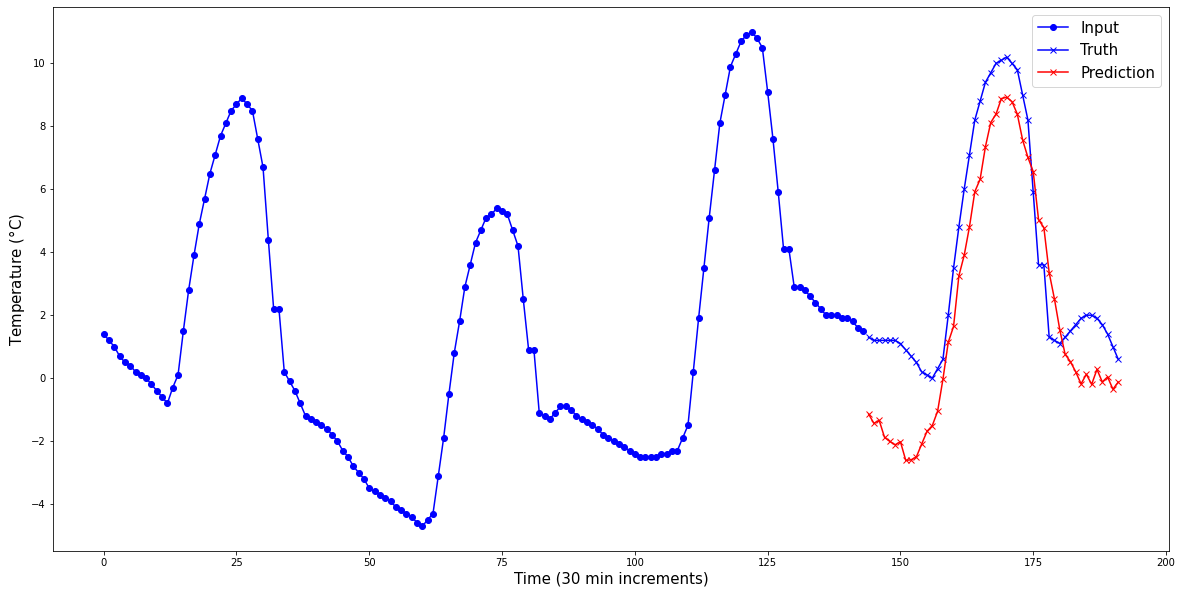

In [ ]:
for batch_to_plot in [21, 22,  8, 29, 27, 13]: 
    _ = plt.figure(figsize=(20, 10))
    _ = plt.plot(range(48*3), X_test[batch_to_plot, :, 0] * scaler.scale_[0] + scaler.mean_[0], marker='o', color='blue', label='Input')
    _ = plt.plot(range(48*3,48*4), Y_test[batch_to_plot, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='blue', label='Truth')
    _ = plt.plot(range(48*3,48*4), model.predict(X_test[batch_to_plot:batch_to_plot+1, :, :])[0, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='red', label='Prediction')
    _ = plt.legend(fontsize=15)
    _ = plt.xlabel("Time (30 min increments)", size=15)
    _ = plt.ylabel("Temperature ($\degree$C)", size=15)
    _ = plt.show()

It is important to point out that our building generalizable and accurate forecasting models is quite difficult, and model definitely still stuggles with some of the time series inputs:

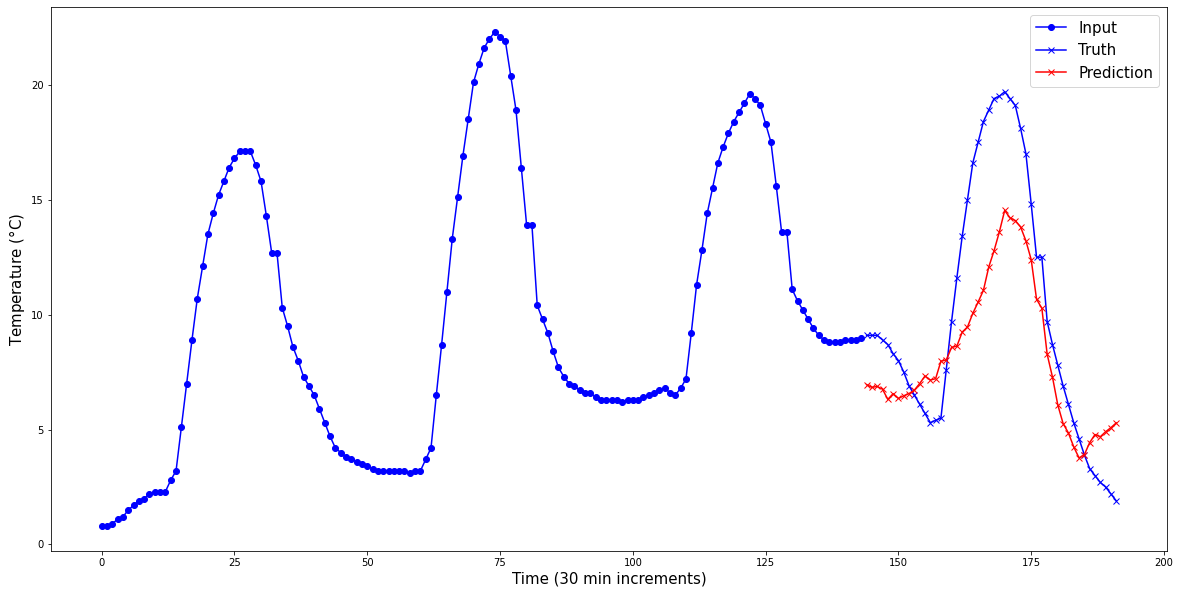

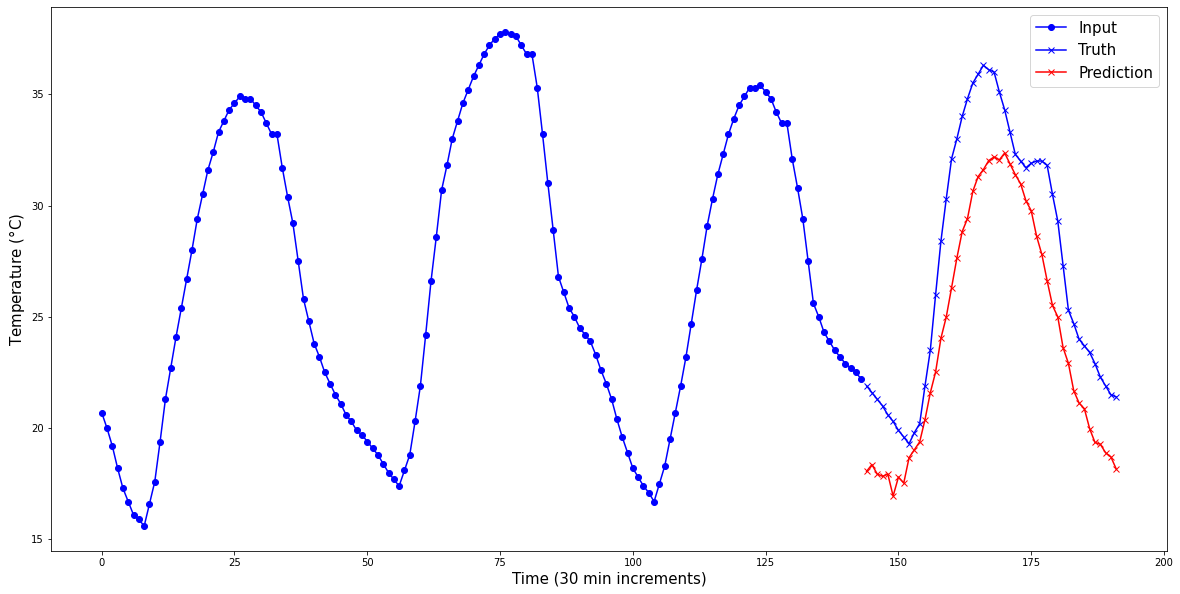

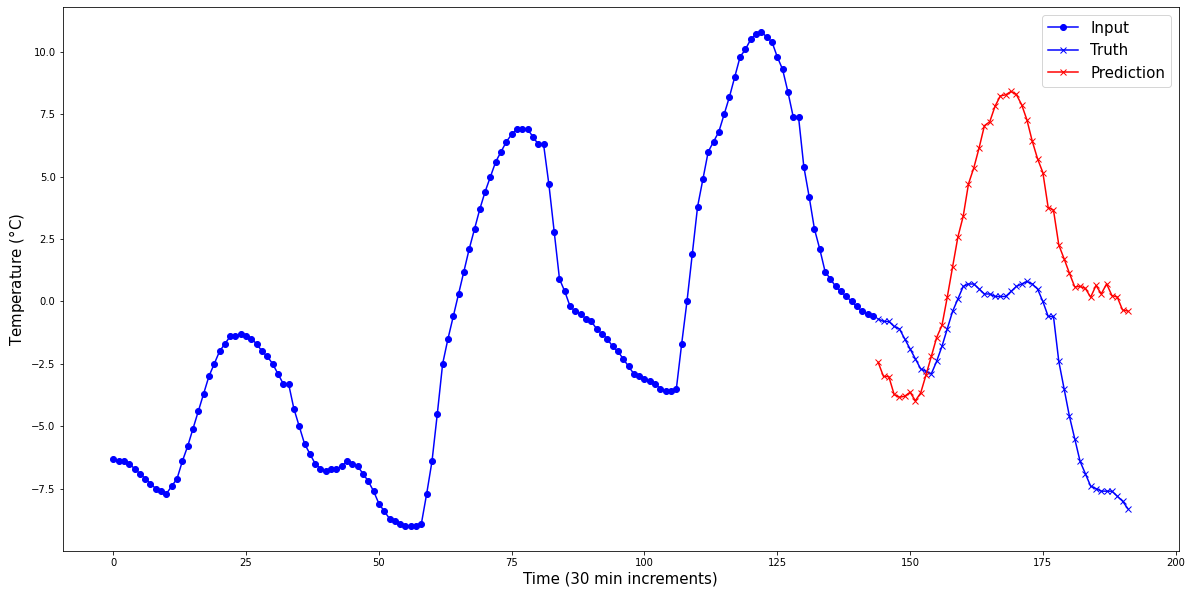

In [ ]:
for batch_to_plot in [0, 5, 36]: 
    _ = plt.figure(figsize=(20, 10))
    _ = plt.plot(range(48*3), X_test[batch_to_plot, :, 0] * scaler.scale_[0] + scaler.mean_[0], marker='o', color='blue', label='Input')
    _ = plt.plot(range(48*3,48*4), Y_test[batch_to_plot, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='blue', label='Truth')
    _ = plt.plot(range(48*3,48*4), model.predict(X_test[batch_to_plot:batch_to_plot+1, :, :])[0, -1, :] * scaler.scale_[0] + scaler.mean_[0], marker='x', color='red', label='Prediction')
    _ = plt.legend(fontsize=15)
    _ = plt.xlabel("Time (30 min increments)", size=15)
    _ = plt.ylabel("Temperature ($\degree$C)", size=15)
    _ = plt.show()

And that's it! Thank you for reading through this Notebook!